In [1]:
# use hmark_env2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import ElasticNetCV, ElasticNet
from inmoose.pycombat import pycombat_norm
import upsetplot
from scipy.stats import binomtest, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import gseapy

# turn on autoreload
%load_ext autoreload
%autoreload 2

source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
    
# read source files–––
from histone_mark_dataset import histoneMarkDataset
from methylation_dataset import methylationDataset
from read_data import DatasetLoader
from download_data import DatasetDownloader
from multi_dataset import MultiDataset

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colorpalettes 
# import palettable
import palettable
# use Prism_10
from palettable.cartocolors.qualitative import Prism_10, Safe_10, Bold_10
dataset_colors = Safe_10.mpl_colors
hmark_colors = Prism_10.mpl_colors
tissue_colors = Bold_10.mpl_colors
from palettable.cartocolors.diverging import Fall_3,Geyser_3, TealRose_3
# create a mapping from datasets to colors
dataset_colors = {
    'encode-human': dataset_colors[0],
    'blueprint-human': dataset_colors[1],
    'encode-mouse': dataset_colors[2],
    'signal-mouse': dataset_colors[3],
    'yang-mouse': dataset_colors[4],
    'stubbs-mouse': dataset_colors[5],
    'hillje-mouse': dataset_colors[6],
    'ceehrc': dataset_colors[7],
    'meer-mouse': dataset_colors[8],
    'petkovich-mouse': dataset_colors[9]
}
# create a mapping from hmarks to colors
hmark_colors = {
    'H3K4me3': hmark_colors[0],
    'H3K36me3': hmark_colors[1],
    'H3K27ac': hmark_colors[2],
    'H3K27me3': hmark_colors[3],
    'H3K9me3': hmark_colors[4],
    'H3K4me1': hmark_colors[5],
    'H3K9ac': hmark_colors[6],
    'H4K20me1': hmark_colors[7],
    'H3K9/14ac':'black',
    'H2A.Zac':'black',
    'methylation':'black',
    'DNAm':'black'
}

In [2]:
# reset rcparams
plt.rcParams.update(plt.rcParamsDefault)
%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Load Data

In [3]:
# human
# methylation and histone
loader = DatasetLoader(dataset_name = 'encode-human', load_methyl = True, load_histone = True)
methyl_human_encode, hmark_human_encode = loader.load_dataset()
# methylation and histone
loader = DatasetLoader(dataset_name = 'blueprint-human', load_methyl = True, load_histone = True)
human_blueprint_methyl, hmark_human_blueprint = loader.load_dataset()

# mouse 
# brain histone
loader = DatasetLoader(dataset_name = 'signal_2024')
signal = loader.load_dataset()
# liver and kidney histone
loader = DatasetLoader(dataset_name = 'yang_2023')
yang = loader.load_dataset()
# methylation and hisotne many tissues (4 mice)
loader = DatasetLoader(dataset_name = 'encode-mouse', load_methyl = True, load_histone = True)
methyl_mouse_encode, hmark_mouse_encode = loader.load_dataset()
# multi tissue methylation 
loader = DatasetLoader(dataset_name = 'stubbs_2017')
stubbs = loader.load_dataset()
# liver histone, w caloric restriction
loader = DatasetLoader(dataset_name = 'hillje_2022')
hillje = loader.load_dataset()

# drop duplicates index
methyl_human_encode.data_matrix_w_meta = methyl_human_encode.data_matrix_w_meta[~methyl_human_encode.data_matrix_w_meta.index.duplicated(keep = 'first')]


histone_datasets = [hmark_human_encode,hmark_human_blueprint,signal, yang, hillje] # hmark_mouse_encode
methyl_datasets = [methyl_human_encode, human_blueprint_methyl, stubbs] # methyl_mouse_encode

Loading dataset: encode-human
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/encode/human_bed_files/methyl/data_matrix/methyl_human_encode_data_matrix_w_meta.parquet
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/encode/human_bed_files/histone/data_matrix/human_encode_hmark_data_matrix_w_meta.parquet
Loading dataset: blueprint-human
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/blueprint/histone/data_matrix/human_blueprint_hmark_data_matrix_w_meta.parquet
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/blueprint/methyl/data_matrix/human_blueprint_methyl_data_matrix_w_meta.parquet
Loading dataset: signal_2024
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/signal_2024/bed_peaks/data_matrix/signal_2024_data_matrix_w_meta.parquet
Loading dataset: yang_2023
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/yang_2023/bed_peaks/da

# Create pan-epigenetic dataset

In [ ]:
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3','H3K36me3', 'H3K9me3',  'H3K4me1', 'methylation'] #
nan_policy = 'fill'
# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets
features = 'all'
pan_epigenetic = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    ~pan_epigenetic.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
"""special_genetic_background_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()"""
special_fibroblast_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples  + special_fibroblast_samples))
pan_epigenetic.exclude_samples = special_samples

# drop excluded samples
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    ~pan_epigenetic.combined_data_matrix.index.isin(pan_epigenetic.exclude_samples)
    ]

# do combat normalization
pan_epigenetic.combat_normalize(batch_col = 'dataset')
# drop rows with any nans
#pan_epigenetic.combined_data_matrix.dropna(inplace=True)

Performing ComBat normalization using dataset as batch...
ComBat normalization complete


# Compute Spearman

In [5]:
correlations = pan_epigenetic.compute_feature_age_correlations(
    group_cols=['species', 'histone_mark'],
    age_col='age_scaled_loglog',
    method='spearman',
    n_jobs=8 
)
correlations['abs_correlation'] = correlations['correlation'].abs()

/cellar/users/zkoch/histone_mark_proj/source/multi_dataset.py:1360: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = spearmanr(feature_vals[mask], y_group[mask])
/cellar/users/zkoch/histone_mark_proj/source/multi_dataset.py:1360: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = spearmanr(feature_vals[mask], y_group[mask])
/cellar/users/zkoch/histone_mark_proj/source/multi_dataset.py:1360: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = spearmanr(feature_vals[mask], y_group[mask])
/cellar/users/zkoch/histone_mark_proj/source/multi_dataset.py:1360: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = spearmanr(feature_vals[mask], y_group[mask])
/cellar/users/zkoch/histone_mark_proj/source/multi_dataset.py:1360: ConstantInputWarning: An input array is constant

# Heatmap of correlations

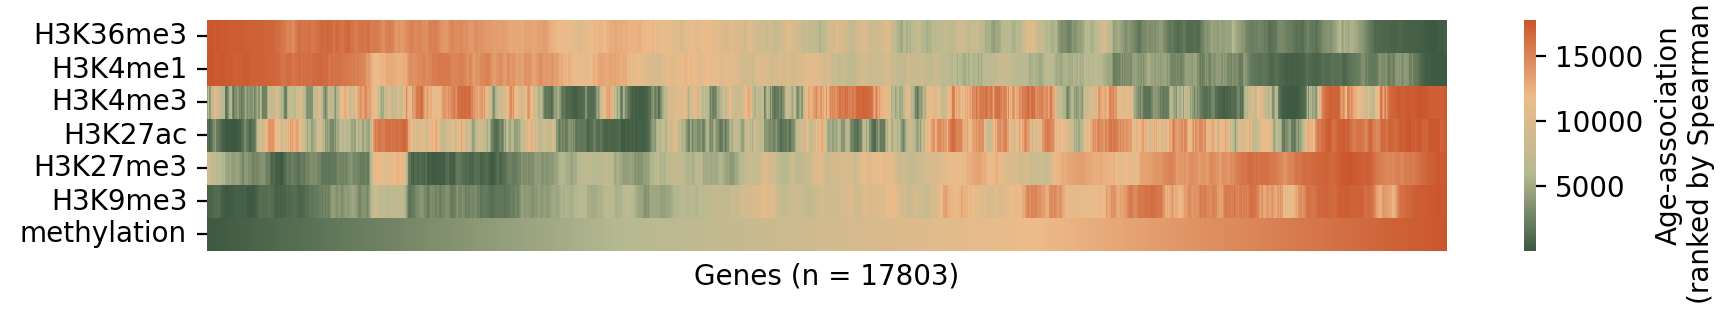

In [9]:

human_correlations_pivoted = correlations[
    (correlations['species'] == 'human')
    ].pivot(index = 'feature', columns = 'histone_mark', values = 'correlation')

human_correlations_pivoted = human_correlations_pivoted.T
human_correlations_pivoted.sort_values(
    by = 'methylation', ascending = True, inplace = True, axis = 1
    )
human_correlations_pivoted = human_correlations_pivoted.rolling(
    window = 500, min_periods = 1, axis = 1, center = True
    ).mean()
human_correlations_pivoted_ranked = human_correlations_pivoted.apply(
    lambda x: x.rank(pct=False), axis = 1
    )

# Cluster rows using hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
row_linkage = linkage(human_correlations_pivoted_ranked, method='average')
# Reorder rows based on clustering
row_dendrogram = dendrogram(row_linkage, no_plot=True)
human_correlations_pivoted_ranked = human_correlations_pivoted_ranked.iloc[row_dendrogram['leaves']]

# plot heatmap with rows reordered
fig, ax = plt.subplots(1, 1, figsize = (10, 1.5))
from palettable.cartocolors.diverging import Temps_6, Fall_4
sns.heatmap(
    # use palettable diverging "Temps_6", converting it to a cmap
    human_correlations_pivoted_ranked, cmap = Fall_4.mpl_colormap,
    ax = ax, xticklabels = False, yticklabels = True, rasterized = True
    )
_ = ax.set_xlabel(f'Genes (n = {human_correlations_pivoted_ranked.shape[1]})')
# name color bar
ax.collections[0].colorbar.set_label('Age-association\n(ranked by Spearman ρ)')
ax.set_ylabel('')
plt.show()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/heatmap_human.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

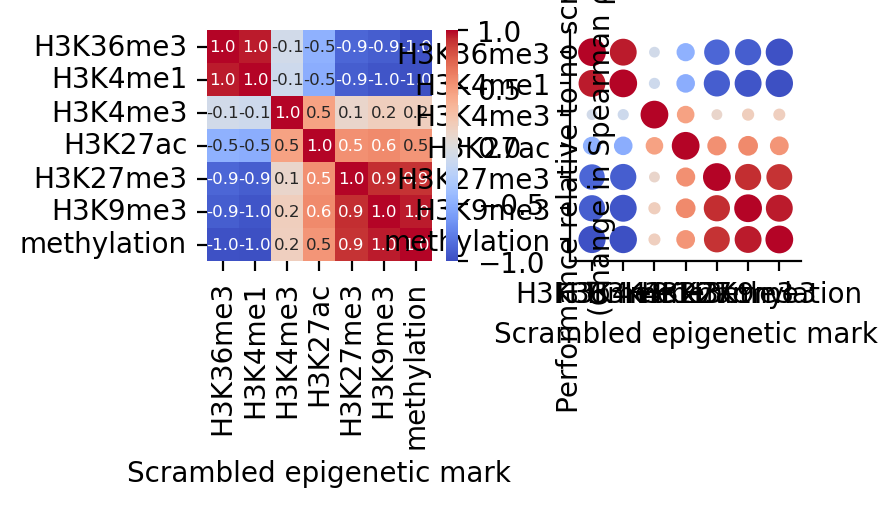

In [7]:
fig, ax = plt.subplots(1,2,figsize = (4,1.5))


corr_of_age_corrs = human_correlations_pivoted.T.corr(method = 'spearman')
                                                                                                                                                              
from palettable.cartocolors.diverging import Temps_3, Fall_3, TealRose_3
sns.heatmap(corr_of_age_corrs.iloc[row_dendrogram['leaves'], row_dendrogram['leaves']], cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, ax = ax[0], annot = True, 
            # format as a percentage
            fmt = '.1f', annot_kws = {'size': 6})
ax[0].set_xlabel('Scrambled epigenetic mark')
ax[0].set_ylabel('')
# label color bar
cbar = ax[0].collections[0].colorbar
cbar.set_label('Performance relative to no scrambling\n(Change in Spearman ρ)')

from palettable.cartocolors.diverging import Temps_3, Fall_3, TealRose_3

# Create circle markers instead of squares
data = corr_of_age_corrs.iloc[row_dendrogram['leaves'], row_dendrogram['leaves']].iloc[::-1, :].values # Reverse both dimensions
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
r = np.abs(data)
colors = plt.cm.coolwarm((data - (-1)) / (1 - (-1)))

# Scale circle sizes based on absolute value, with minimum size of 0.1 and max of 0.4
max_radius = 0.4
min_radius = 0.1
abs_data = np.abs(data)
scaled_sizes = min_radius + (max_radius - min_radius) * (abs_data / abs_data.max())

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        circle = plt.Circle((j + 0.5, i + 0.5), scaled_sizes[i,j],
                          color=colors[i,j])
        ax[1].add_patch(circle)
        # Add text annotation
        """ax[1].text(j + 0.5, i + 0.5, f'{data[i,j]:.2f}', 
                ha='center', va='center', color='black',
                fontsize=4
                )"""

ax[1].set_xlim(-0.2, data.shape[1] + 0.2)
ax[1].set_ylim(-0.2, data.shape[0] + 0.2)
ax[1].set_xticks(np.arange(data.shape[1]) + 0.5)
ax[1].set_yticks(np.arange(data.shape[0]) + 0.5)
ax[1].set_xticklabels(corr_of_age_corrs.iloc[row_dendrogram['leaves'], row_dendrogram['leaves']].columns)
ax[1].set_yticklabels(corr_of_age_corrs.iloc[row_dendrogram['leaves'], row_dendrogram['leaves']].index[::-1])    # Reverse order
ax[1].set_aspect('equal')


ax[1].set_xlabel('Scrambled epigenetic mark')
ax[1].set_ylabel('')
sns.despine(ax = ax[1])

fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/corr_of_age_corrs.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [40]:
# Calculate p-values for correlations between age correlations
from scipy.stats import spearmanr

# Initialize empty DataFrame with same shape as corr_of_age_corrs
pvals = pd.DataFrame(
    np.zeros(corr_of_age_corrs.shape), 
    index=corr_of_age_corrs.index,
    columns=corr_of_age_corrs.columns
)

# Calculate p-values for each pair
for i in corr_of_age_corrs.index:
    for j in corr_of_age_corrs.columns:
        _, pvals.loc[i,j] = spearmanr(
            human_correlations_pivoted.loc[i],
            human_correlations_pivoted.loc[j]
        )
print(pvals.iloc[row_dendrogram['leaves'], row_dendrogram['leaves']])

histone_mark      H3K36me3       H3K4me1        H3K4me3  H3K27ac  \
histone_mark                                                       
H3K36me3      0.000000e+00  0.000000e+00   3.344182e-35      0.0   
H3K4me1       0.000000e+00  0.000000e+00   2.806812e-52      0.0   
H3K4me3       3.344182e-35  2.806812e-52   0.000000e+00      0.0   
H3K27ac       0.000000e+00  0.000000e+00   0.000000e+00      0.0   
H3K27me3      0.000000e+00  0.000000e+00   7.108292e-39      0.0   
H3K9me3       0.000000e+00  0.000000e+00  3.741947e-116      0.0   
methylation   0.000000e+00  0.000000e+00  6.245215e-103      0.0   

histone_mark      H3K27me3        H3K9me3    methylation  
histone_mark                                              
H3K36me3      0.000000e+00   0.000000e+00   0.000000e+00  
H3K4me1       0.000000e+00   0.000000e+00   0.000000e+00  
H3K4me3       7.108292e-39  3.741947e-116  6.245215e-103  
H3K27ac       0.000000e+00   0.000000e+00   0.000000e+00  
H3K27me3      0.000000e+00   0.00

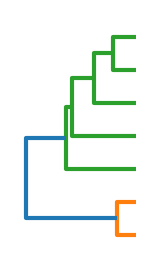

In [145]:
# plot dendrogram on its own axes
fig, ax = plt.subplots(1, 1, figsize = (.75, 1.5))
# set color of dendrogram to black
dendrogram(row_linkage, ax = ax, orientation = 'left')
# remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/dendrogram_human.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)


# Overlap between age-associated genes across epigenetic marks

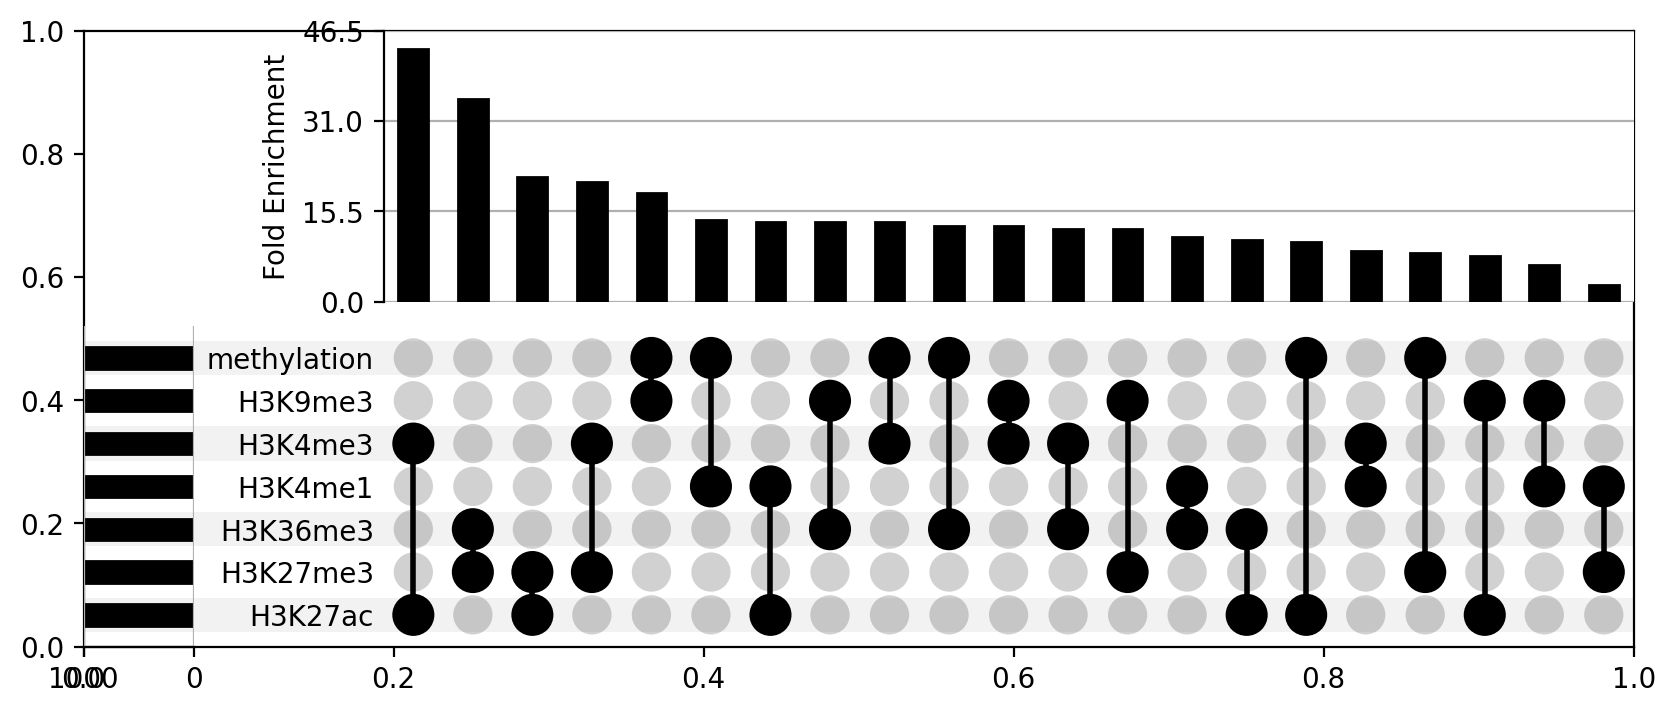

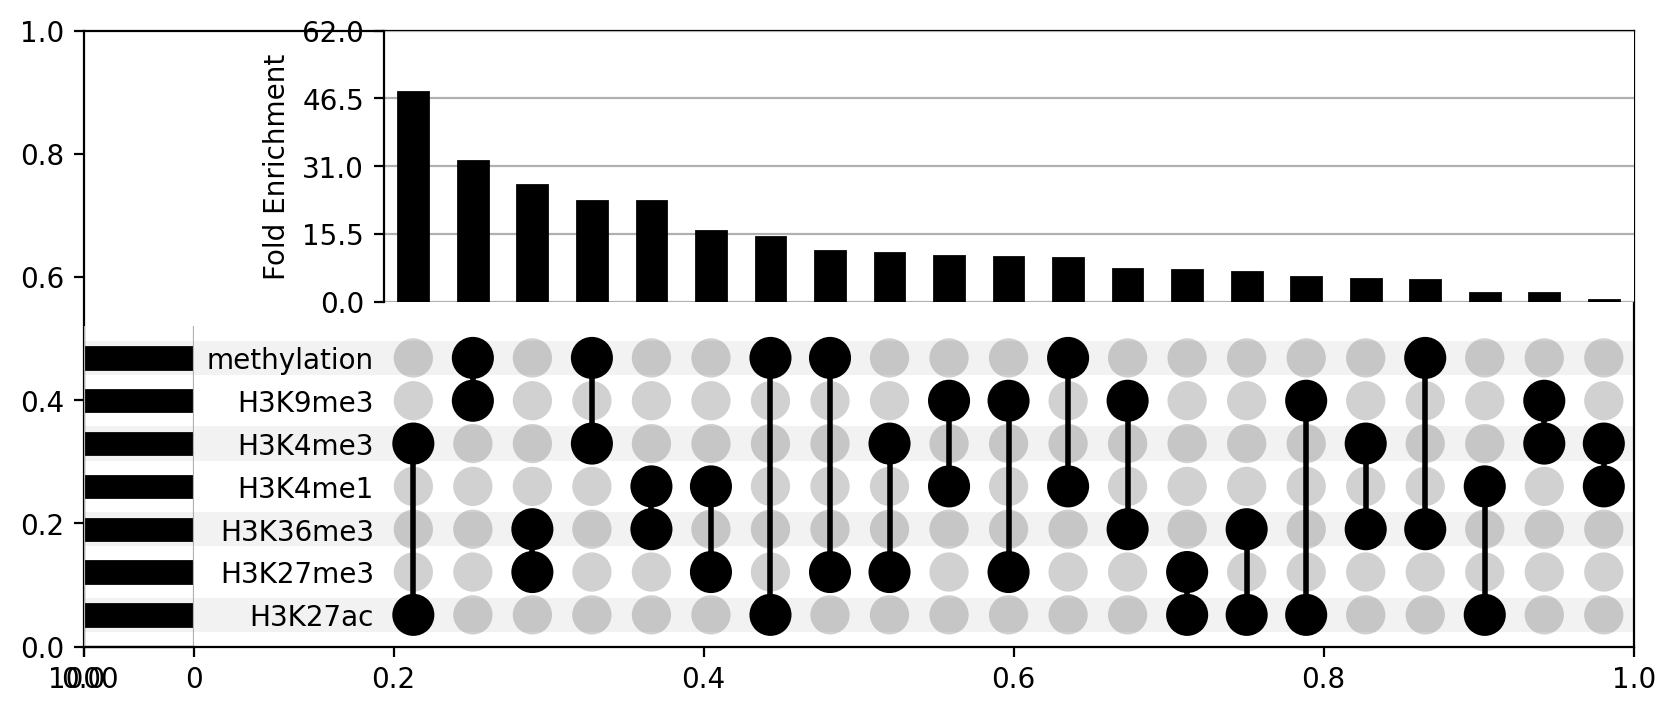

In [20]:
# iterate over the histone marks and get the top 1,000 most age associated genes
topn = 1000
top_age_associations_human = {}
top_age_associations_mouse = {}
for hmark in correlations['histone_mark'].unique():
    top_features = correlations[(correlations['histone_mark'] == hmark) & (correlations['species'] == 'human')].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
    top_age_associations_human[hmark] = top_features
    top_features = correlations[(correlations['histone_mark'] == hmark) & (correlations['species'] == 'mouse')].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
    top_age_associations_mouse[hmark] = top_features
upset_top_age_associations_human = upsetplot.from_contents(top_age_associations_human)
upset_top_age_associations_mouse = upsetplot.from_contents(top_age_associations_mouse)

# the expected overlap is the number of features times the proportion of features that we define as age associated (top 1000 / total number of features)
expected_overlap = topn * (topn / correlations['feature'].nunique())**2

# create upset plot only including pairs of overlaps
fig_human, ax_human = plt.subplots(1, 1, figsize = (10, 4))
a = upsetplot.plot(
    upset_top_age_associations_human, 
    include_empty_subsets = False,
    min_degree = 2,
    max_degree = 2,
    fig = fig_human,
    element_size = None,
    # sort by size of intersection
    sort_by = 'cardinality'
    )
# Get the current y-axis labels and divide by expected_overlap
ax_list = fig_human.axes
for ax in ax_list:
    if ax.get_ylabel() == 'Intersection size':
        # Get current tick positions and labels
        positions = ax.get_yticks()
        labels = ax.get_yticklabels()
        # Create new labels divided by expected overlap
        new_labels = [f'{float(l.get_text())/expected_overlap:.1f}' for l in labels]
        # Set new labels while keeping positions
        ax.set_yticks(positions)
        ax.set_yticklabels(new_labels)
        ax.set_ylabel('Fold Enrichment')
fig_human.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/upset_human.svg',  dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
plt.show()

# create upset plot only including pairs of overlaps
fig_mouse, ax_mouse = plt.subplots(1, 1, figsize = (10, 4))
a = upsetplot.plot(
    upset_top_age_associations_mouse, 
    include_empty_subsets = False,
    min_degree = 2,
    max_degree = 2,
    fig = fig_mouse,
    element_size = None,
    # sort by size of intersection
    sort_by = 'cardinality'
    )
# Get the current y-axis labels and divide by expected_overlap
ax_list = fig_mouse.axes
for ax in ax_list:
    if ax.get_ylabel() == 'Intersection size':
        # Get current tick positions and labels
        positions = ax.get_yticks()
        labels = ax.get_yticklabels()
        # Create new labels divided by expected overlap
        new_labels = [f'{float(l.get_text())/expected_overlap:.1f}' for l in labels]
        # Set new labels while keeping positions
        ax.set_yticks(positions)
        ax.set_yticklabels(new_labels)
        ax.set_ylabel('Fold Enrichment')
fig_mouse.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/upset_mouse.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
plt.show()

In [10]:
overlaps = {}
already_done_pairs = {}
# for each pair of epi marks
for hmark1 in correlations['histone_mark'].unique():
    for hmark2 in correlations['histone_mark'].unique():
        # and each species
        for species in correlations['species'].unique():
            if hmark1 != hmark2 and (hmark1, hmark2, species) not in overlaps.keys() and (hmark2, hmark1, species) not in overlaps.keys():
                # get top 1000 features based on age association for each mark
                top_features_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == species)].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
                top_features_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['species'] == species)].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
                overlap = len(set(top_features_hmark1) & set(top_features_hmark2))
                overlaps[(hmark1, hmark2, species)] = overlap
                
# create df from overlaps dict
overlap_df = pd.DataFrame.from_dict(overlaps, orient = 'index', columns = ['overlap'])
overlap_df.index = pd.MultiIndex.from_tuples(overlap_df.index, names = ['hmark1', 'hmark2', 'species'])
overlap_df.reset_index(inplace = True)
overlap_df.sort_values(by = 'overlap', ascending = False, inplace = True)
overlap_df['epi_marks'] = overlap_df['hmark1'] + '_' + overlap_df['hmark2']
# calculcate enrichment
overlap_df['expected_overlap'] =  topn * (topn / correlations['feature'].nunique())**2
overlap_df['fold_enrichment'] = overlap_df['overlap'] / overlap_df['expected_overlap']
overlap_df['log2_fold_enrichment'] = np.log2(overlap_df['fold_enrichment'])
# apply binomial test
overlap_df['pvalue'] = overlap_df.apply(lambda row: binomtest(row['overlap'], topn,( topn / correlations['feature'].nunique())**2).pvalue, axis = 1)
# adjust pvalues
overlap_df['bonferroni_pvalue'] = multipletests(overlap_df['pvalue'], method = 'bonferroni')[1]

In [14]:
overlap_df.query('species == "mouse"')

,hmark1,hmark2,species,overlap,epi_marks,expected_overlap,fold_enrichment,log2_fold_enrichment,pvalue,bonferroni_pvalue
41,H3K9me3,methylation,mouse,112,H3K9me3_methylation,3.155104,35.498043,5.149668,3.805356e-131,1.598249e-129
23,H3K36me3,H3K4me1,mouse,97,H3K36me3_H3K4me1,3.155104,30.743840,4.942225,1.271425e-107,5.339984e-106
7,H3K27ac,H3K4me3,mouse,92,H3K27ac_H3K4me3,3.155104,29.159106,4.865875,5.080156e-100,2.133665e-98
13,H3K27me3,H3K36me3,mouse,86,H3K27me3_H3K36me3,3.155104,27.257426,4.768577,4.534632e-91,1.904545e-89
17,H3K27me3,H3K4me3,mouse,80,H3K27me3_H3K4me3,3.155104,25.355745,4.664241,2.566726e-82,1.078025e-80
39,H3K4me3,methylation,mouse,73,H3K4me3_methylation,3.155104,23.137117,4.532137,2.254535e-72,9.469046e-71
33,H3K4me1,H3K9me3,mouse,59,H3K4me1_H3K9me3,3.155104,18.699862,4.224956,1.872516e-53,7.864565e-52
11,H3K27ac,methylation,mouse,48,H3K27ac_methylation,3.155104,15.213447,3.927275,1.207546e-39,5.071691e-38
3,H3K27ac,H3K36me3,mouse,48,H3K27ac_H3K36me3,3.155104,15.213447,3.927275,1.207546e-39,5.071691e-38
1,H3K27ac,H3K27me3,mouse,46,H3K27ac_H3K27me3,3.155104,14.579553,3.865875,2.999845e-37,1.259935e-35


In [13]:
overlap_df.query('species == "human"')#[['epi_marks', 'bonferroni_pvalue']]


,hmark1,hmark2,species,overlap,epi_marks,expected_overlap,fold_enrichment,log2_fold_enrichment,pvalue,bonferroni_pvalue
6,H3K27ac,H3K4me3,human,256,H3K27ac_H3K4me3,3.155104,81.138383,6.342313,0.000000e+00,0.000000e+00
4,H3K27ac,H3K4me1,human,121,H3K27ac_H3K4me1,3.155104,38.350564,5.261176,9.733814e-146,4.088202e-144
0,H3K27ac,H3K27me3,human,120,H3K27ac_H3K27me3,3.155104,38.033617,5.249203,4.229559e-144,1.776415e-142
30,H3K4me1,H3K4me3,human,119,H3K4me1_H3K4me3,3.155104,37.716670,5.237130,1.820587e-142,7.646463e-141
12,H3K27me3,H3K36me3,human,118,H3K27me3_H3K36me3,3.155104,37.399723,5.224956,7.762512e-141,3.260255e-139
16,H3K27me3,H3K4me3,human,116,H3K27me3_H3K4me3,3.155104,36.765830,5.200294,1.371158e-137,5.758863e-136
28,H3K36me3,methylation,human,101,H3K36me3_methylation,3.155104,32.011628,5.000524,8.589096e-114,3.607420e-112
26,H3K36me3,H3K9me3,human,100,H3K36me3_H3K9me3,3.155104,31.694681,4.986169,3.046335e-112,1.279461e-110
22,H3K36me3,H3K4me1,human,96,H3K36me3_H3K4me1,3.155104,30.426894,4.927275,4.311783e-106,1.810949e-104
38,H3K4me3,methylation,human,94,H3K4me3_methylation,3.155104,29.793000,4.896901,4.790826e-103,2.012147e-101


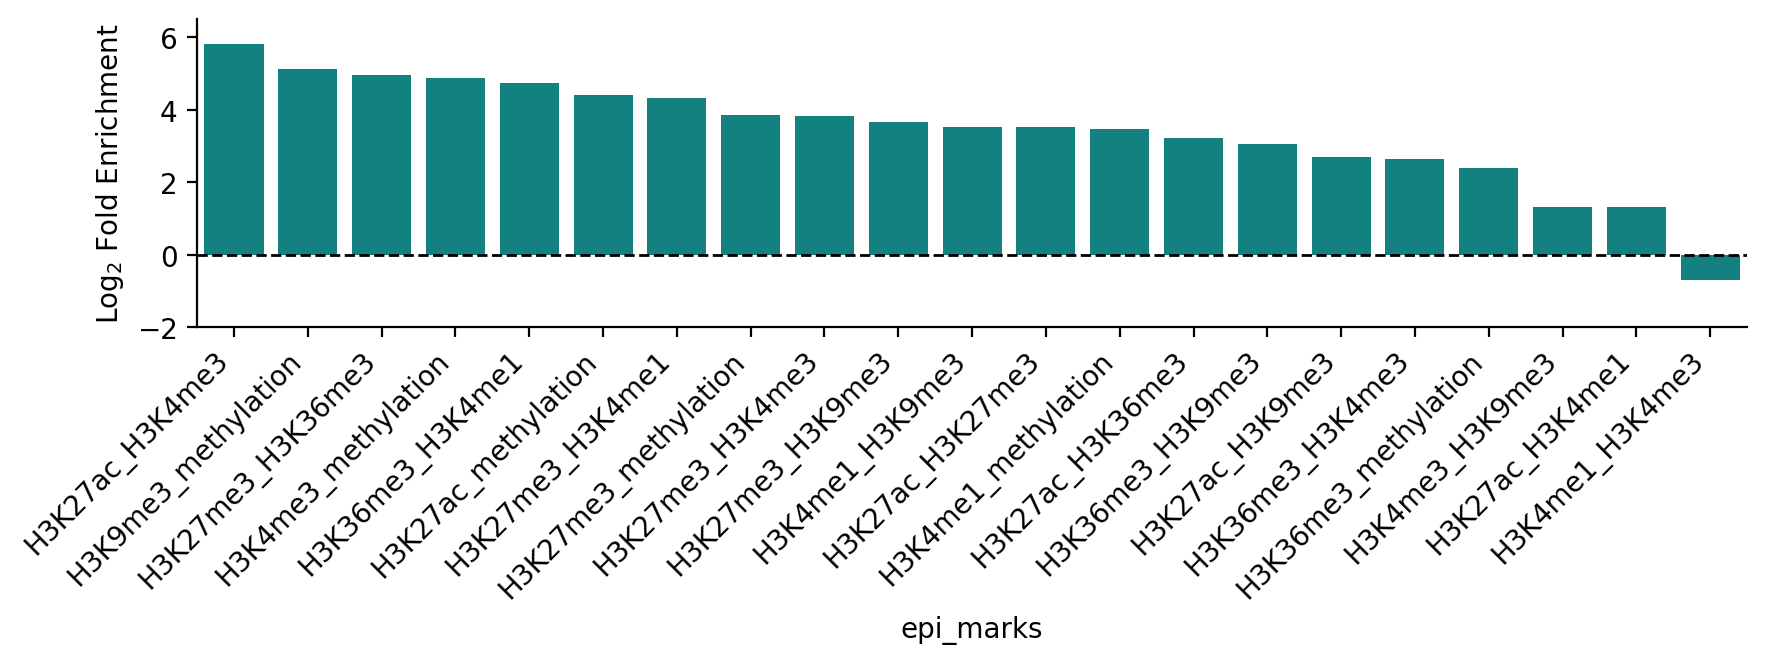

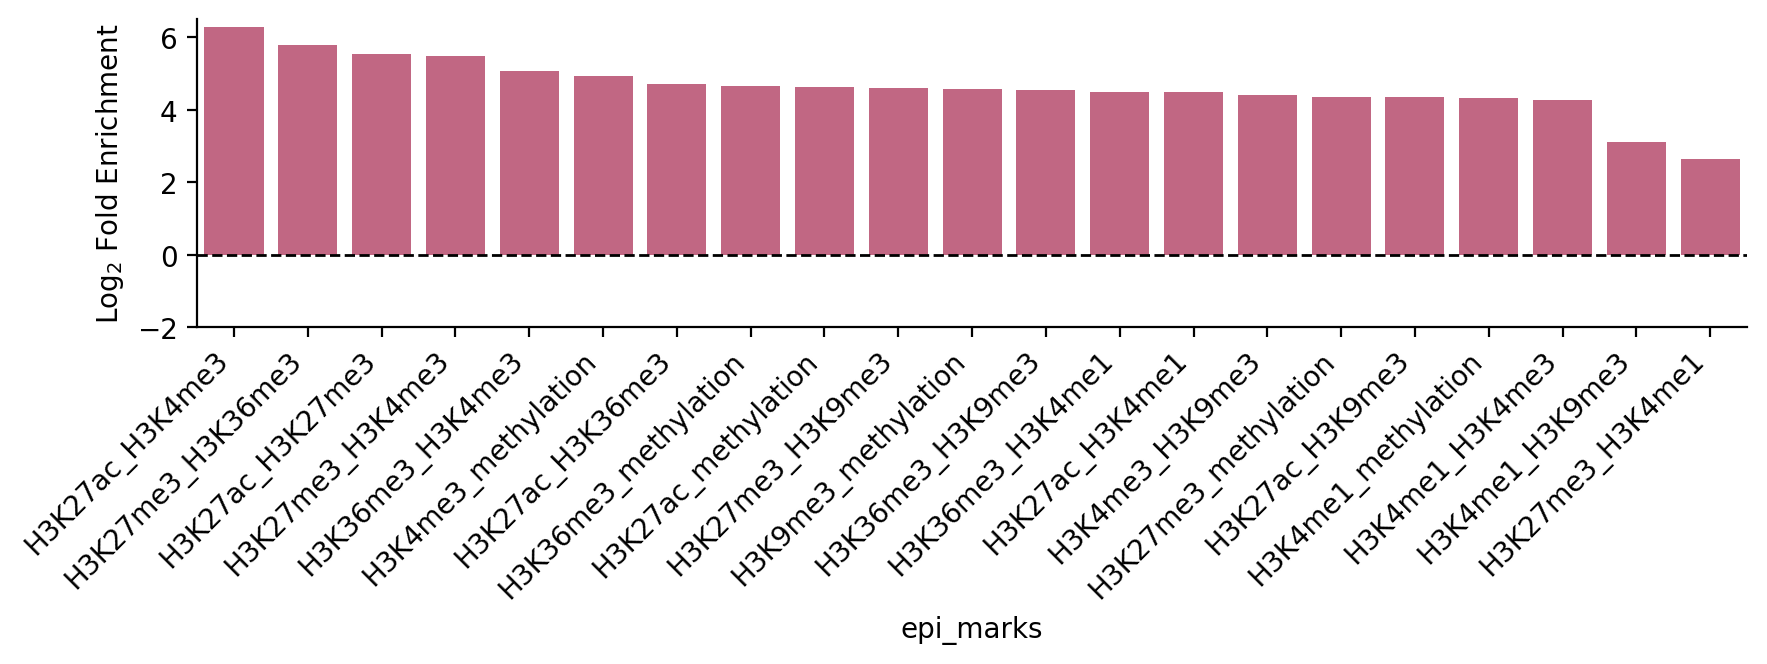

In [21]:
fig_mouse, ax_mouse = plt.subplots(1, 1, figsize = (10, 2))
order = overlap_df.query('species == "mouse"').sort_values(by = 'log2_fold_enrichment', ascending = False)['epi_marks'].tolist()
sns.barplot(data = overlap_df.query('species == "mouse"'), x = 'epi_marks', y = 'log2_fold_enrichment', ax = ax_mouse, color = TealRose_3.mpl_colors[0], order = order)
# angle x labels
ax_mouse.set_xticklabels(ax_mouse.get_xticklabels(), rotation=45, ha='right')
sns.despine(ax = ax_mouse)
# draw dashed line at 0
ax_mouse.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
# set ylabel, use subscripts for log2
ax_mouse.set_ylabel('Log$_2$ Fold Enrichment')
# set ylim to be same as human
ax_mouse.set_ylim(-2, 6.5)
fig_mouse.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/enrichment_bars_mouse.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
plt.show()

fig_human, ax_human = plt.subplots(1, 1, figsize = (10, 2))
order = overlap_df.query('species == "human"').sort_values(by = 'log2_fold_enrichment', ascending = False)['epi_marks'].tolist()
sns.barplot(data = overlap_df.query('species == "human"'), x = 'epi_marks', y = 'log2_fold_enrichment', ax = ax_human, color = TealRose_3.mpl_colors[2], order = order)
# angle x labels
ax_human.set_xticklabels(ax_human.get_xticklabels(), rotation=45, ha='right')
sns.despine(ax = ax_human)
# draw dashed line at 0
ax_human.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
# set ylim to be same as mouse
ax_human.set_ylim(ax_mouse.get_ylim())
# set ylabel, use subscripts for log2
ax_human.set_ylabel('Log$_2$ Fold Enrichment')
fig_human.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/enrichment_bars_human.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
plt.show()



# Overlap between age-associated sites between species

In [15]:
species_overlaps = {}
# for each pair of epi marks
for hmark1 in correlations['histone_mark'].unique():
    # get top 1000 features based on age association for each mark
    top_features_human = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
    top_features_mouse = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'mouse')].sort_values(by = 'abs_correlation', ascending = False).head(topn)['feature'].tolist()
    overlap = len(set(top_features_human) & set(top_features_mouse))
    species_overlaps[hmark1] = overlap
                
# create df from overlaps dict
species_overlap_df = pd.DataFrame.from_dict(species_overlaps, orient = 'index', columns = ['overlap'])
species_overlap_df.reset_index(inplace = True)
species_overlap_df.sort_values(by = 'overlap', ascending = False, inplace = True)
# calculcate enrichment
species_overlap_df['expected_overlap'] =  topn * (topn / correlations['feature'].nunique())**2
species_overlap_df['fold_enrichment'] = species_overlap_df['overlap'] / species_overlap_df['expected_overlap']
species_overlap_df['log2_fold_enrichment'] = np.log2(species_overlap_df['fold_enrichment'])
# apply binomial test
species_overlap_df['pvalue'] = species_overlap_df.apply(lambda row: binomtest(row['overlap'], topn, (topn / correlations['feature'].nunique())**2).pvalue, axis = 1)
# adjust pvalues
species_overlap_df['bonferroni_pvalue'] = multipletests(species_overlap_df['pvalue'], method = 'bonferroni')[1]

In [23]:
species_overlap_df['bonferroni_pvalue']

6    6.178930e-167
5     7.935796e-94
3     1.379499e-83
4     1.183628e-54
0     9.060509e-51
1     1.210037e-33
2     4.280921e-29
Name: bonferroni_pvalue, dtype: float64

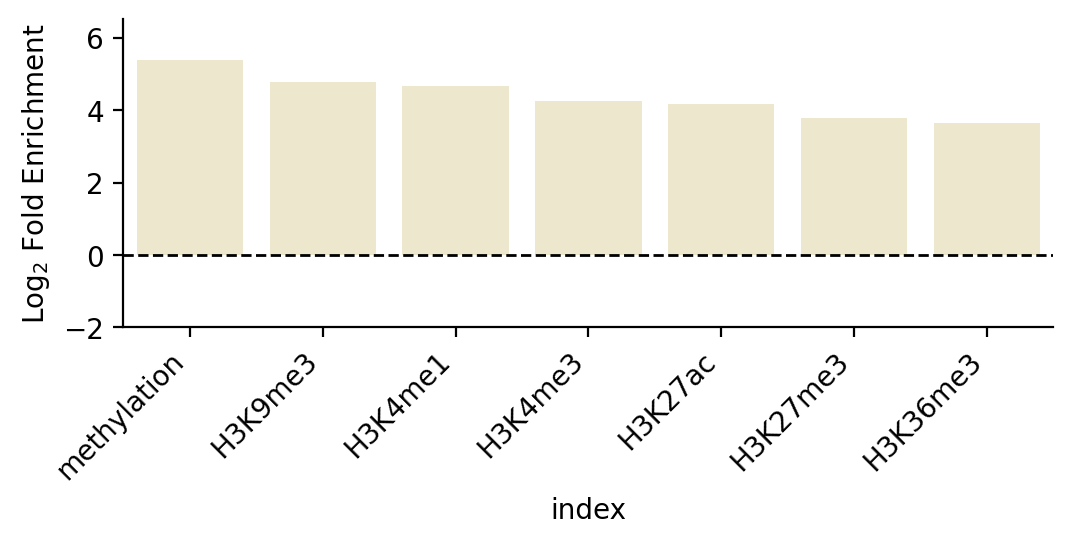

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (6, 2))
sns.barplot(data = species_overlap_df, x = 'index', y = 'log2_fold_enrichment', color = TealRose_3.mpl_colors[1], ax = ax)
sns.despine(ax = ax)
# angle x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# set ylabel, use subscripts for log2
ax.set_ylabel('Log$_2$ Fold Enrichment')
# set ylim to be same as human
ax.set_ylim(-2, 6.5)
# add line at 0
ax.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/overlap_between_species_bars.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
plt.show()

# Overlap between all layers

### Humans

In [77]:
# create a categorical colormap with 4 colors from Fall_4
# get 4 colors from Fall_4 as a list of rgb tuples
cmap = [Fall_4.mpl_colors[i] for i in range(4)]


In [91]:
colors = ['blue', 'green', 'yellow', 'red']

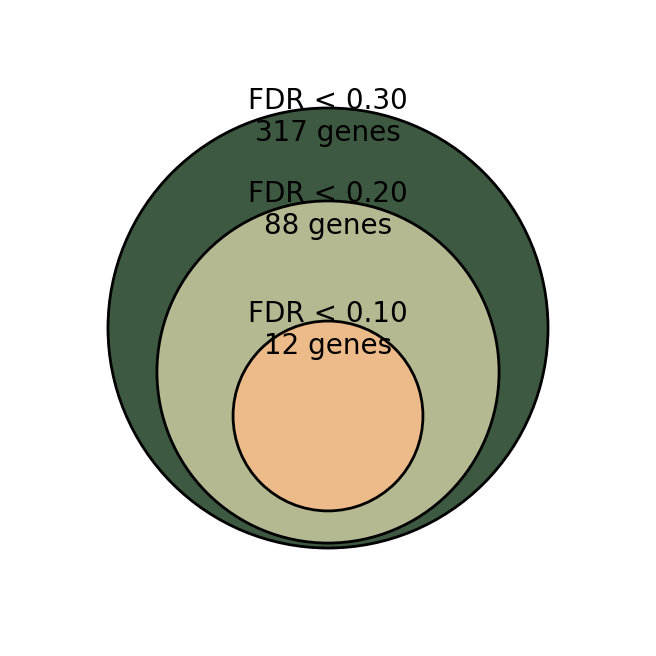

In [136]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# create a figure and axis
fig, ax = plt.subplots(1, 1, figsize = (4,4))

# list of radii for nested circles
fdr_five = correlations.query('species == "human" and p_value < 0.1')['feature'].value_counts().value_counts().loc[7]
fdr_ten = correlations.query('species == "human" and p_value < 0.2')['feature'].value_counts().value_counts().loc[7]
fdr_twentyfive = correlations.query('species == "human" and p_value < 0.3')['feature'].value_counts().value_counts().loc[7]
radii = [fdr_five, fdr_ten, fdr_twentyfive]
radii = [np.log10(r) for r in radii]
# add circles to the plot
alpha_values = [0.05, 0.1, 0.25]

# reverse the order of radii and alpha_values
radii = radii[::-1]
alpha_values = alpha_values[::-1]

for i, r_alpha in enumerate(zip(radii, alpha_values)):
    r, alpha = r_alpha
    circle = Circle((0, 0-0.5*i), r, edgecolor='black', fill=True, alpha=1, facecolor=cmap[i], linewidth=1, )
    ax.add_patch(circle)

# set aspect ratio to equal to ensure circles are round
ax.set_aspect('equal', 'box')
ax.set_xlim(-max(radii)-1, max(radii)+1)
ax.set_ylim(-max(radii)-1, max(radii)+1)

# annotate each circle with the number of features
fdrs = [0.1, 0.2, 0.3][::-1]
for i, r in enumerate(radii):
    # raise r to the power of 10
    ax.text(0, r-0.5*i-.1, f'FDR < {fdrs[i]:.2f}\n{10**r:.0f} genes', ha='center', va='center', color = 'black')

# remove all spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/fdr_circles.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

# Interaction

### All vs. All

In [6]:
results_dict = {}
# change hmark1
for hmark1 in ['H3K4me1', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me3', 'H3K9me3', 'methylation']:
    # see effect on hmark2
    for hmark2 in ['H3K4me1', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me3', 'H3K9me3', 'methylation']:
        # get the 1,000 sites with highest corrleation for hmark1
        top_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(1000)['feature'].tolist()
        bottom_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(1000)['feature'].tolist()
        
        # background distribution of all age associations for hmark2
        background_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['species'] == 'human')]
        # get the correlation for hmark2 for the top_sites_hmark1
        top_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(top_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna().tolist()
        # get the correlation for hmark2 for the bottom_sites_hmark1
        bottom_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(bottom_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna().tolist()
        
        # test difference between top_sites_hmark1_hmark2 and bottom_sites_hmark1_hmark2
        mwu_p = mannwhitneyu(top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2).pvalue
        # calculate median difference
        median_diff = np.median(top_sites_hmark1_hmark2) - np.median(bottom_sites_hmark1_hmark2)

        results_dict[(hmark1, hmark2)] = {'mwu_p': mwu_p, 'median_diff': median_diff}

# convert to df
results_df = pd.DataFrame(results_dict)
results_df = results_df.T.reset_index().rename(columns = {'level_0': 'hmark1', 'level_1': 'hmark2'})


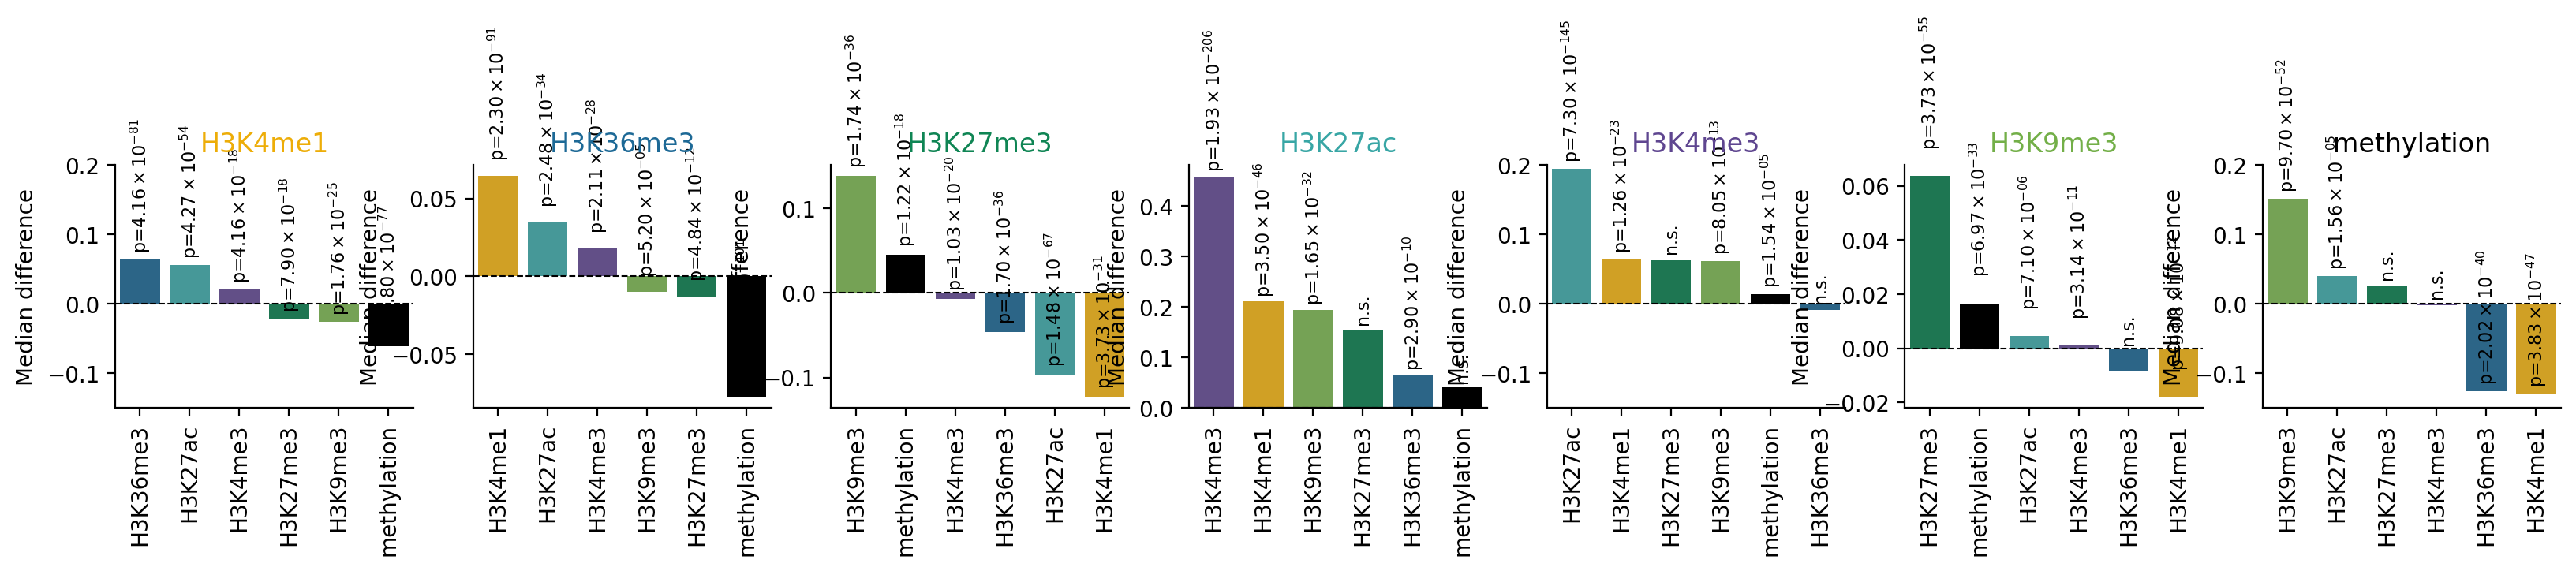

In [33]:
# create a facet plot with one subplot per hmark1
fig, axes = plt.subplots(1, 7, figsize = (20, 2), sharey=False)
axes = axes.flatten()

# for the hmark2 we are observing effect on 
for i, hmark2 in enumerate(results_df['hmark2'].unique()):
    # get rows where hmark2 is istelf and hmark1 is not
    this_hmark = results_df.loc[(results_df['hmark1'] != hmark2) & (results_df['hmark2'] == hmark2)]
    this_hmark.sort_values('median_diff', ascending=False, inplace=True)
    # set x order to be descending order of affecting hmarks
    order = this_hmark['hmark1'].tolist()
    sns.barplot(
        data = this_hmark,
        x = 'hmark1',
        y = 'median_diff',
        ax = axes[i],
        hue = 'hmark1',
        palette= hmark_colors,
        order = order
    )
    axes[i].set_title(f'{hmark2}', color = hmark_colors[hmark2])
    # pivot x labels 90 degrees
    axes[i].tick_params(axis='x', rotation=90)
    # draw dashed line at 0
    axes[i].axhline(y=0, linestyle='--', color='black', alpha=1, linewidth = 0.75)
    axes[i].set_ylabel('Median difference')
    axes[i].set_xlabel('')
    
    # add respective p value above each bar
    # get p-values for this hmark, ordered by median_diff
    pvals = this_hmark['mwu_p']
    # get bar positions
    bar_positions = axes[i].patches
    # reverse order of bar_positions
    #bar_positions = bar_positions[::-1]
    # add p-values above each bar
    for j, bar in enumerate(bar_positions):
        # get p-value for this bar
        pval = pvals.iloc[j]
        if pval > 0.01:
            pval_str = f'n.s.'
        else:
            pval_str_start = f'{pval:.2e}'.split('e')[0]
            pval_str_end = f'{pval:.2e}'.split('e')[-1]
            pval_str = f'p=${pval_str_start} \\times 10^{{{pval_str_end}}}$'
        
        # get bar height
        height = bar.get_height()
        # add text above bar
        axes[i].text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            pval_str,
            ha='center',
            va='bottom',
            rotation=90,
            fontsize=8
        )

    if hmark2 in ['H3K4me1', 'methylation', 'H3K4me3']:
        # set ylim to be -0.2 to 0.2
        axes[i].set_ylim(-0.15, 0.2)

sns.despine()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/all_vs_all_facet_plot.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/interactions/all_vs_all_facet_plot.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)


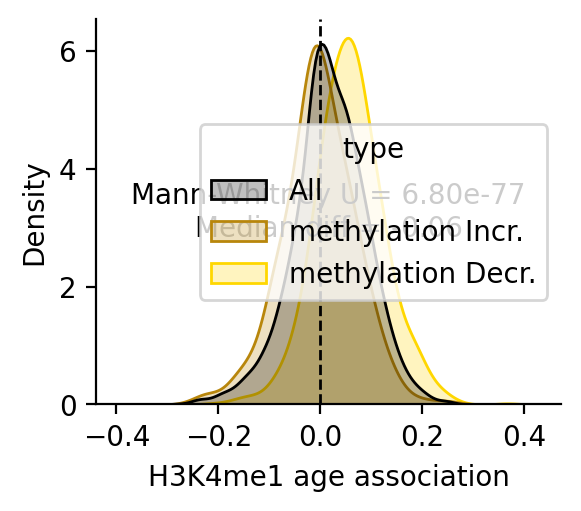

In [37]:
results_dict = {}
hmark1 = 'methylation'
hmark2 = 'H3K4me1'

# get the 1,000 sites with highest corrleation for hmark1
top_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(1000)['feature'].tolist()
bottom_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(1000)['feature'].tolist()

# background distribution of all age associations for hmark2
background_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['species'] == 'human')]
# get the correlation for hmark2 for the top_sites_hmark1
top_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(top_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna().tolist()
# get the correlation for hmark2 for the bottom_sites_hmark1
bottom_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(bottom_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna().tolist()

to_plot_df = pd.DataFrame({'correlation': np.concatenate([background_hmark2['correlation'], top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2]), 'type': np.concatenate([np.repeat('All', len(background_hmark2)), np.repeat(f'{hmark1} Incr.', len(top_sites_hmark1_hmark2)), np.repeat(f'{hmark1} Decr.', len(bottom_sites_hmark1_hmark2))])})

fig, ax = plt.subplots(1, 1, figsize = (3, 2.5))
this_hmark_color = hmark_colors[hmark2]
# create a light and darker version of this color by adjusting alpha
this_hmark_color_light = sns.color_palette([this_hmark_color])[0]
this_hmark_color_dark = sns.color_palette([this_hmark_color])[0]
# make the light color lighter by mixing with white
this_hmark_color_light = tuple([0.7*x + 0.3 for x in this_hmark_color_light])
# make the dark color darker by reducing brightness
this_hmark_color_dark = tuple([0.7*x for x in this_hmark_color_dark])

sns.kdeplot(data=to_plot_df, x='correlation', hue='type', palette=['black', 'darkgoldenrod', 'gold'], ax=ax, common_norm=False, fill=True, bw_adjust=1.25)
ax.set_xlabel(f'{hmark2} age association')
# draw dashed line at 0
ax.axvline(0, color='black', linestyle='--', linewidth=1)
sns.despine()


# add mwu pvalue and median difference to the plot
mwu_p = mannwhitneyu(top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2).pvalue
median_diff = np.median(top_sites_hmark1_hmark2) - np.median(bottom_sites_hmark1_hmark2)
ax.text(0.5, 0.5, f'Mann-Whitney U = {mwu_p:.2e}\nMedian diff = {median_diff:.2f}', ha='center', va='center', transform=ax.transAxes)
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/methylation_vs_h3k4me1_kde.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

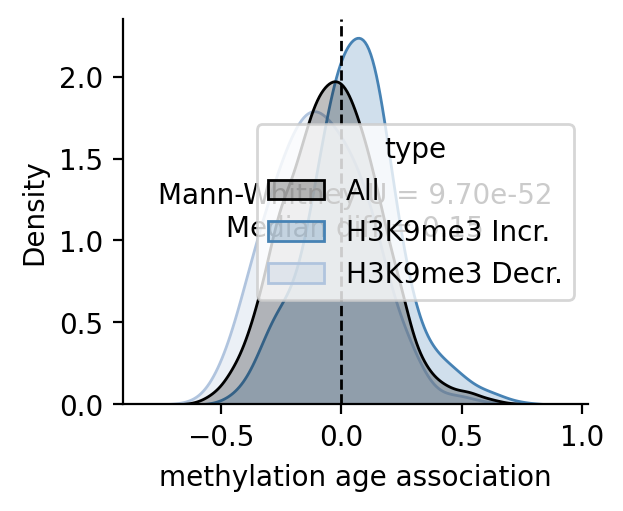

In [38]:
results_dict = {}
hmark1 = 'H3K9me3'
hmark2 = 'methylation'

# get the 1,000 sites with highest corrleation for hmark1
top_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(1000)['feature'].tolist()
bottom_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(1000)['feature'].tolist()

# background distribution of all age associations for hmark2
background_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['species'] == 'human')]
# get the correlation for hmark2 for the top_sites_hmark1
top_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(top_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna()
# get the correlation for hmark2 for the bottom_sites_hmark1
bottom_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(bottom_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna()

to_plot_df = pd.DataFrame({'correlation': np.concatenate([background_hmark2['correlation'], top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2]), 'type': np.concatenate([np.repeat('All', len(background_hmark2)), np.repeat(f'{hmark1} Incr.', len(top_sites_hmark1_hmark2)), np.repeat(f'{hmark1} Decr.', len(bottom_sites_hmark1_hmark2))])})

fig, ax = plt.subplots(1, 1, figsize = (3, 2.5))
this_hmark_color = hmark_colors[hmark2]
# create a light and darker version of this color by adjusting alpha
this_hmark_color_light = sns.color_palette([this_hmark_color])[0]
this_hmark_color_dark = sns.color_palette([this_hmark_color])[0]
# make the light color lighter by mixing with white
this_hmark_color_light = tuple([0.7*x + 0.3 for x in this_hmark_color_light])
# make the dark color darker by reducing brightness
this_hmark_color_dark = tuple([0.7*x for x in this_hmark_color_dark])

sns.kdeplot(data=to_plot_df, x='correlation', hue='type', palette=['black','steelblue', 'lightsteelblue'], ax=ax, common_norm=False, fill=True, bw_adjust=1.25)
ax.set_xlabel(f'{hmark2} age association')
ax.set_xlabel(f'{hmark2} age association')
# draw dashed line at 0
ax.axvline(0, color='black', linestyle='--', linewidth=1)
sns.despine()

# add mwu pvalue and median difference to the plot
mwu_p = mannwhitneyu(top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2).pvalue
median_diff = np.median(top_sites_hmark1_hmark2) - np.median(bottom_sites_hmark1_hmark2)
ax.text(0.5, 0.5, f'Mann-Whitney U = {mwu_p:.2e}\nMedian diff = {median_diff:.2f}', ha='center', va='center', transform=ax.transAxes)
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/h3k9me3_vs_methylation_kde.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

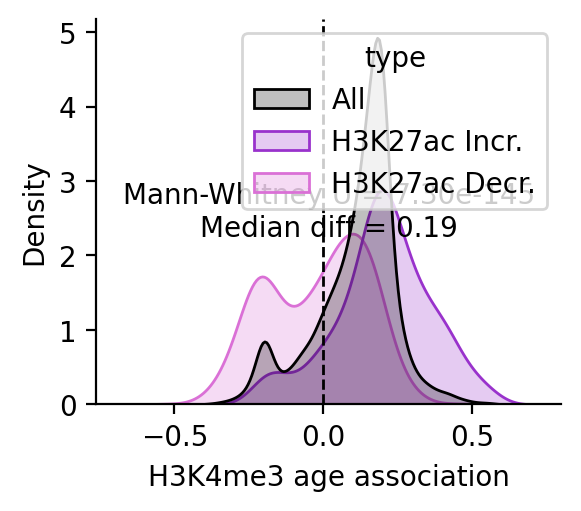

In [39]:
results_dict = {}
hmark1 = 'H3K27ac'
hmark2 = 'H3K4me3'

# get the 1,000 sites with highest corrleation for hmark1
top_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(1000)['feature'].tolist()
bottom_sites_hmark1 = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(1000)['feature'].tolist()

# background distribution of all age associations for hmark2
background_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['species'] == 'human')]
# get the correlation for hmark2 for the top_sites_hmark1
top_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(top_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna()
# get the correlation for hmark2 for the bottom_sites_hmark1
bottom_sites_hmark1_hmark2 = correlations[(correlations['histone_mark'] == hmark2) & (correlations['feature'].isin(bottom_sites_hmark1)) & (correlations['species'] == 'human')]['correlation'].dropna()

to_plot_df = pd.DataFrame({'correlation': np.concatenate([background_hmark2['correlation'], top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2]), 'type': np.concatenate([np.repeat('All', len(background_hmark2)), np.repeat(f'{hmark1} Incr.', len(top_sites_hmark1_hmark2)), np.repeat(f'{hmark1} Decr.', len(bottom_sites_hmark1_hmark2))])})

fig, ax = plt.subplots(1, 1, figsize = (3, 2.5))

sns.kdeplot(data=to_plot_df, x='correlation', hue='type', palette=['black', 'darkorchid', 'orchid'], ax=ax, common_norm=False, fill=True, bw_adjust=1.25)
ax.set_xlabel(f'{hmark2} age association')
ax.set_xlabel(f'{hmark2} age association')
# draw dashed line at 0
ax.axvline(0, color='black', linestyle='--', linewidth=1)
sns.despine()

# add mwu pvalue and median difference to the plot
mwu_p = mannwhitneyu(top_sites_hmark1_hmark2, bottom_sites_hmark1_hmark2).pvalue
median_diff = np.median(top_sites_hmark1_hmark2) - np.median(bottom_sites_hmark1_hmark2)
ax.text(0.5, 0.5, f'Mann-Whitney U = {mwu_p:.2e}\nMedian diff = {median_diff:.2f}', ha='center', va='center', transform=ax.transAxes)
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/h3k27ac_vs_h3k4me3_kde.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

# Enrichment

In [9]:
def plot_enrichment_analysis(enrichment_up, enrichment_down, ax,  down_genes, up_genes, colors = ['lightblue', 'coral']):
    """
    Plot the top 10 results by P-value for up and down-regulated genes
    
    Params
    ------
    enrichment_up: pd.DataFrame
        The enrichment results for up-regulated genes 
    enrichment_down: pd.DataFrame
        The enrichment results for down-regulated genes
    ax: matplotlib.axes.Axes
        The axes to plot the enrichment results on
    down_genes: list of str
        The down-regulated genes in sorted in increasing order of fold change
    up_genes: list of str
        The up-regulated genes in sorted in decreasing order of fold change
    colors: list of str
        The colors to use for the up and down-regulated bars
    """
    # select top 10 results by Adjusted P-value	
    down_top = enrichment_down.results.sort_values(by='Adjusted P-value', ascending=True)
    up_top = enrichment_up.results.sort_values(by='Adjusted P-value', ascending=True)
    # remove results that have only 1 gene
    down_top = down_top[down_top['Genes'].str.split(';').str.len() > 1]
    up_top = up_top[up_top['Genes'].str.split(';').str.len() > 1]
    # drop infs or nans in P-Value, Combined Score, Odds Ratio
    # mask inf wiht nan
    down_top = down_top.replace([np.inf, -np.inf], np.nan)
    up_top = up_top.replace([np.inf, -np.inf], np.nan)
    down_top = down_top.dropna(subset=['Adjusted P-value', 'Combined Score', 'Odds Ratio'])
    up_top = up_top.dropna(subset=['Adjusted P-value', 'Combined Score', 'Odds Ratio'])
    # make sure these are significant
    #down_top = down_top.query("`Adjusted P-value` < 0.05").head(10)
    #up_top = up_top.query("`Adjusted P-value` < 0.05").head(10)
    down_top = down_top.query("`Adjusted P-value` < 0.05").head(10)
    up_top = up_top.query("`Adjusted P-value` < 0.05").head(10)
    # make the odds ratio negative for down
    down_top['Odds Ratio'] = -down_top['Odds Ratio']
    down_top['Combined Score'] = -down_top['Combined Score']
    down_top['direction'] = 'down'
    up_top['direction'] = 'up'
    # combine the dfs
    updown = pd.concat([down_top, up_top])
    
    # split Term on (G) and take the first part
    updown['Term'] = updown['Term'].str.split(' \(GO').str[0]
    # split Term on R-HSA and take the first part
    updown['Term'] = updown['Term'].str.split(' R-HSA').str[0]
    
    order = updown.sort_values(by='Combined Score', ascending=True)['Term'].tolist()
    sns.barplot(
        y='Term', x='Combined Score', data=updown, 
        hue='direction', palette=colors, 
        order=order, ax=ax, legend=False
        )
    # angle the x-axis labels
    ax.set_ylabel('')
    ax.set_xlabel('Enrichment Score')
    # plot vertical line at 0
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    
    # Add gene labels on top of each bar
    for idx, row in updown.iterrows():
        genes = row['Genes'].split(';')  # Split gene string into list
        # Calculate y position and alignment based on direction
        if row['direction'] == 'up':
            x_pos = 1#max(0, row['Combined Score'])
            ha = 'left'
            # sort genes by their position in the up_genes list
            genes = [g for g in up_genes if g in genes]
        else:
            x_pos = -1 #min(0, row['Combined Score'])
            ha = 'right'
            # sort genes by their position in the down_genes list
            genes = [g for g in down_genes if g in genes]
        # subset to the first 5 genes
        genes = genes[:5]  # Limit to first 5 genes to avoid overcrowding
        gene_text = ', '.join(genes)  # Join genes with newlines
        # Calculate x position (bar center)
        y_pos = order.index(row['Term'])
        # Add text
        ax.text(x_pos, y_pos, gene_text, 
                ha=ha, va='center',
                fontsize=8, rotation=0)
        
    sns.despine()

In [12]:
repressive_marks = ['H3K27me3', 'H3K9me3', 'methylation']
topn = 1000
repressive_complete_overlap = set()
# for each pair of epi marks
for hmark1 in correlations['histone_mark'].unique():
    if hmark1 in repressive_marks:
        top_features_human = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(topn)['feature'].tolist()
        top_features_mouse = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'mouse')].sort_values(by = 'correlation', ascending = False).dropna().head(topn)['feature'].tolist()
    else:
        top_features_human = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(topn)['feature'].tolist()
        top_features_mouse = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'mouse')].sort_values(by = 'correlation', ascending = False).dropna().tail(topn)['feature'].tolist()
    # add to complete overlap set
    repressive_complete_overlap.update(set(top_features_human) & set(top_features_mouse))
# convert to df
repressive_complete_overlap_df = pd.DataFrame({'feature': list(repressive_complete_overlap)})
# convert to gene symbols
gene_conversion = pd.read_csv('/cellar/users/zkoch/histone_mark_proj/utils/ensembl_to_geneSymbol.tsv', sep = '\t', index_col = 0, header = None)
repressive_complete_overlap_df['feature'] = repressive_complete_overlap_df['feature'].map(gene_conversion.to_dict()[1])
correlations['gene_names'] = correlations['feature'].map(gene_conversion.to_dict()[1])

activating_complete_overlap = set()
# for each epi mark
for hmark1 in correlations['histone_mark'].unique():
    if hmark1 in repressive_marks:
        top_features_human = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().tail(topn)['feature'].tolist()
        top_features_mouse = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'mouse')].sort_values(by = 'correlation', ascending = False).dropna().tail(topn)['feature'].tolist()
    else:
        top_features_human = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'human')].sort_values(by = 'correlation', ascending = False).dropna().head(topn)['feature'].tolist()
        top_features_mouse = correlations[(correlations['histone_mark'] == hmark1) & (correlations['species'] == 'mouse')].sort_values(by = 'correlation', ascending = False).dropna().head(topn)['feature'].tolist()
    # add to complete overlap set
    activating_complete_overlap.update(set(top_features_human) & set(top_features_mouse))
# convert to dfdd
activating_complete_overlap_df = pd.DataFrame({'feature': list(activating_complete_overlap)})
# convert to gene symbols
gene_conversion = pd.read_csv('/cellar/users/zkoch/histone_mark_proj/utils/ensembl_to_geneSymbol.tsv', sep = '\t', index_col = 0, header = None)
activating_complete_overlap_df['feature'] = activating_complete_overlap_df['feature'].map(gene_conversion.to_dict()[1])
correlations['gene_names'] = correlations['feature'].map(gene_conversion.to_dict()[1])

# measure GO enrichment of genes that are top 1,000 in all marks and species
repressive_go = gseapy.enrichr(
    gene_list = repressive_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['GO_Biological_Process_2023'],
    )
activating_go = gseapy.enrichr(
    gene_list = activating_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['GO_Biological_Process_2023'],
    )

repressive_reactome = gseapy.enrichr(
    gene_list = repressive_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['Reactome_Pathways_2024'],
    )

activating_reactome = gseapy.enrichr(
    gene_list = activating_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['Reactome_Pathways_2024'],
    )

In [14]:
activating_complete_overlap_df

,feature
0,OCIAD1
1,RETREG2
2,C14orf119
3,OTOG
4,TESPA1
...,...
422,NDUFS8
423,GOLIM4
424,GORASP2
425,SCN2B


In [135]:
# measure GO enrichment of genes that are top 1,000 in all marks and species
repressive_go = gseapy.enrichr(
    gene_list = repressive_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['GO_Biological_Process_2023'],
    )
activating_go = gseapy.enrichr(
    gene_list = activating_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['GO_Biological_Process_2023'],
    )

repressive_reactome = gseapy.enrichr(
    gene_list = repressive_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['Reactome_Pathways_2024'],
    )

activating_reactome = gseapy.enrichr(
    gene_list = activating_complete_overlap_df['feature'].dropna().tolist(),
    background =  correlations['gene_names'].dropna().unique().tolist(),
    gene_sets = ['Reactome_Pathways_2024'],
    )


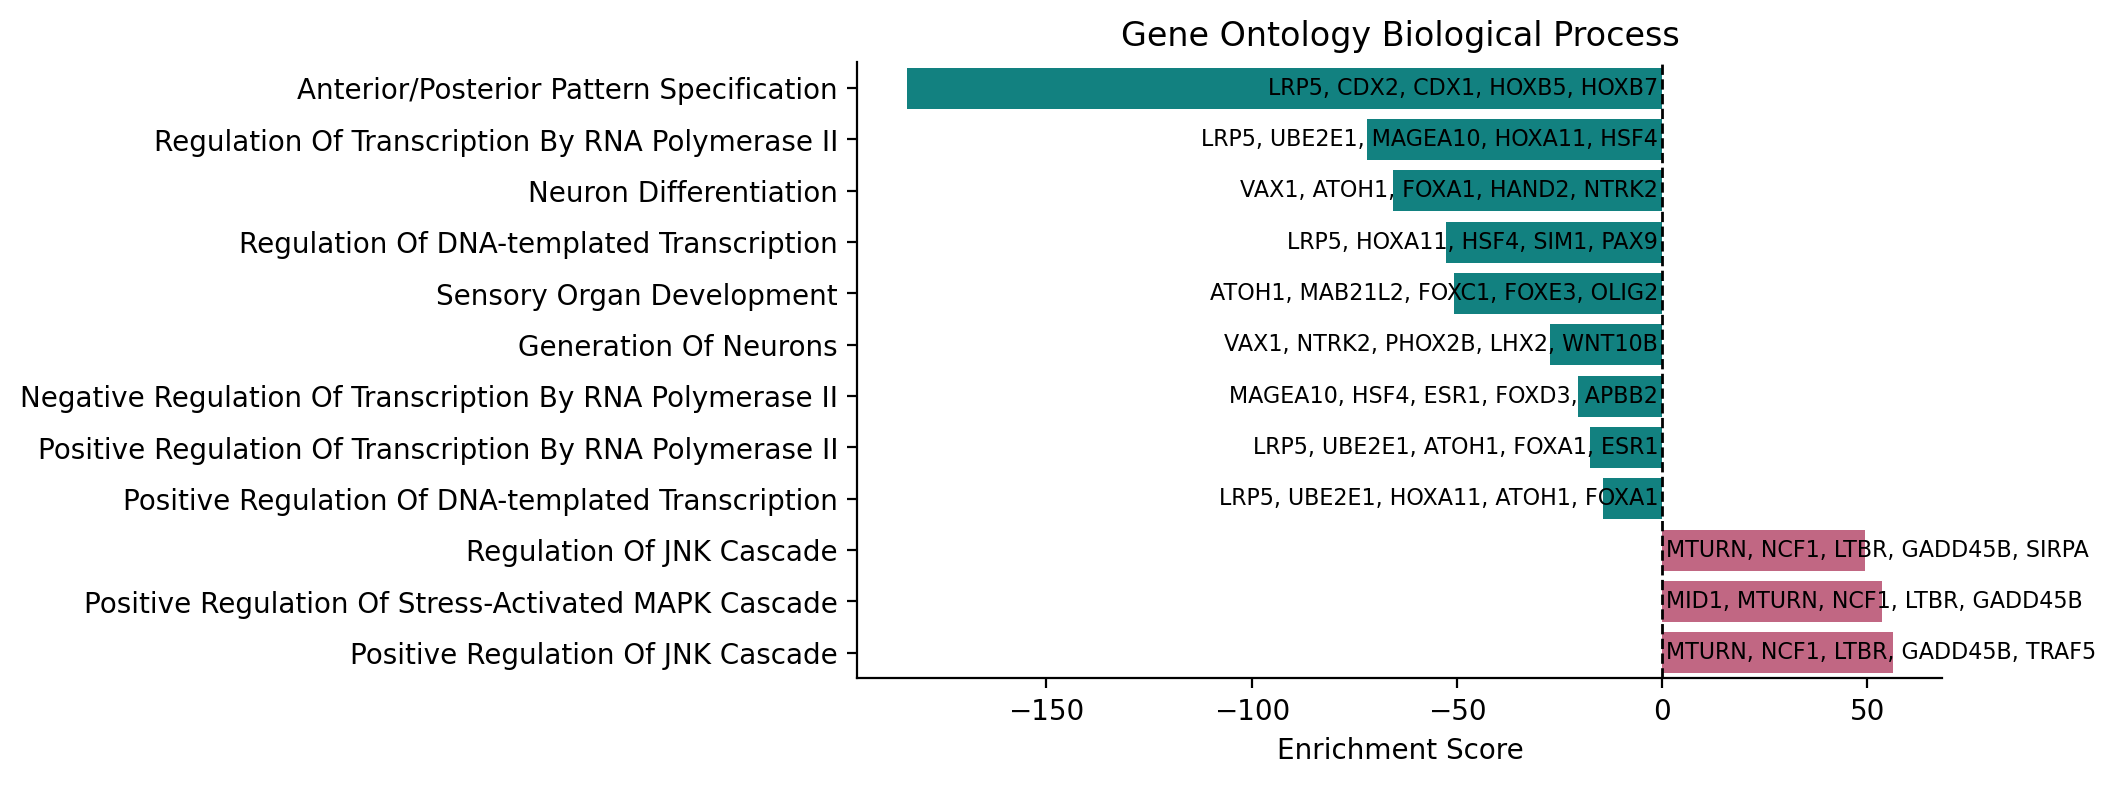

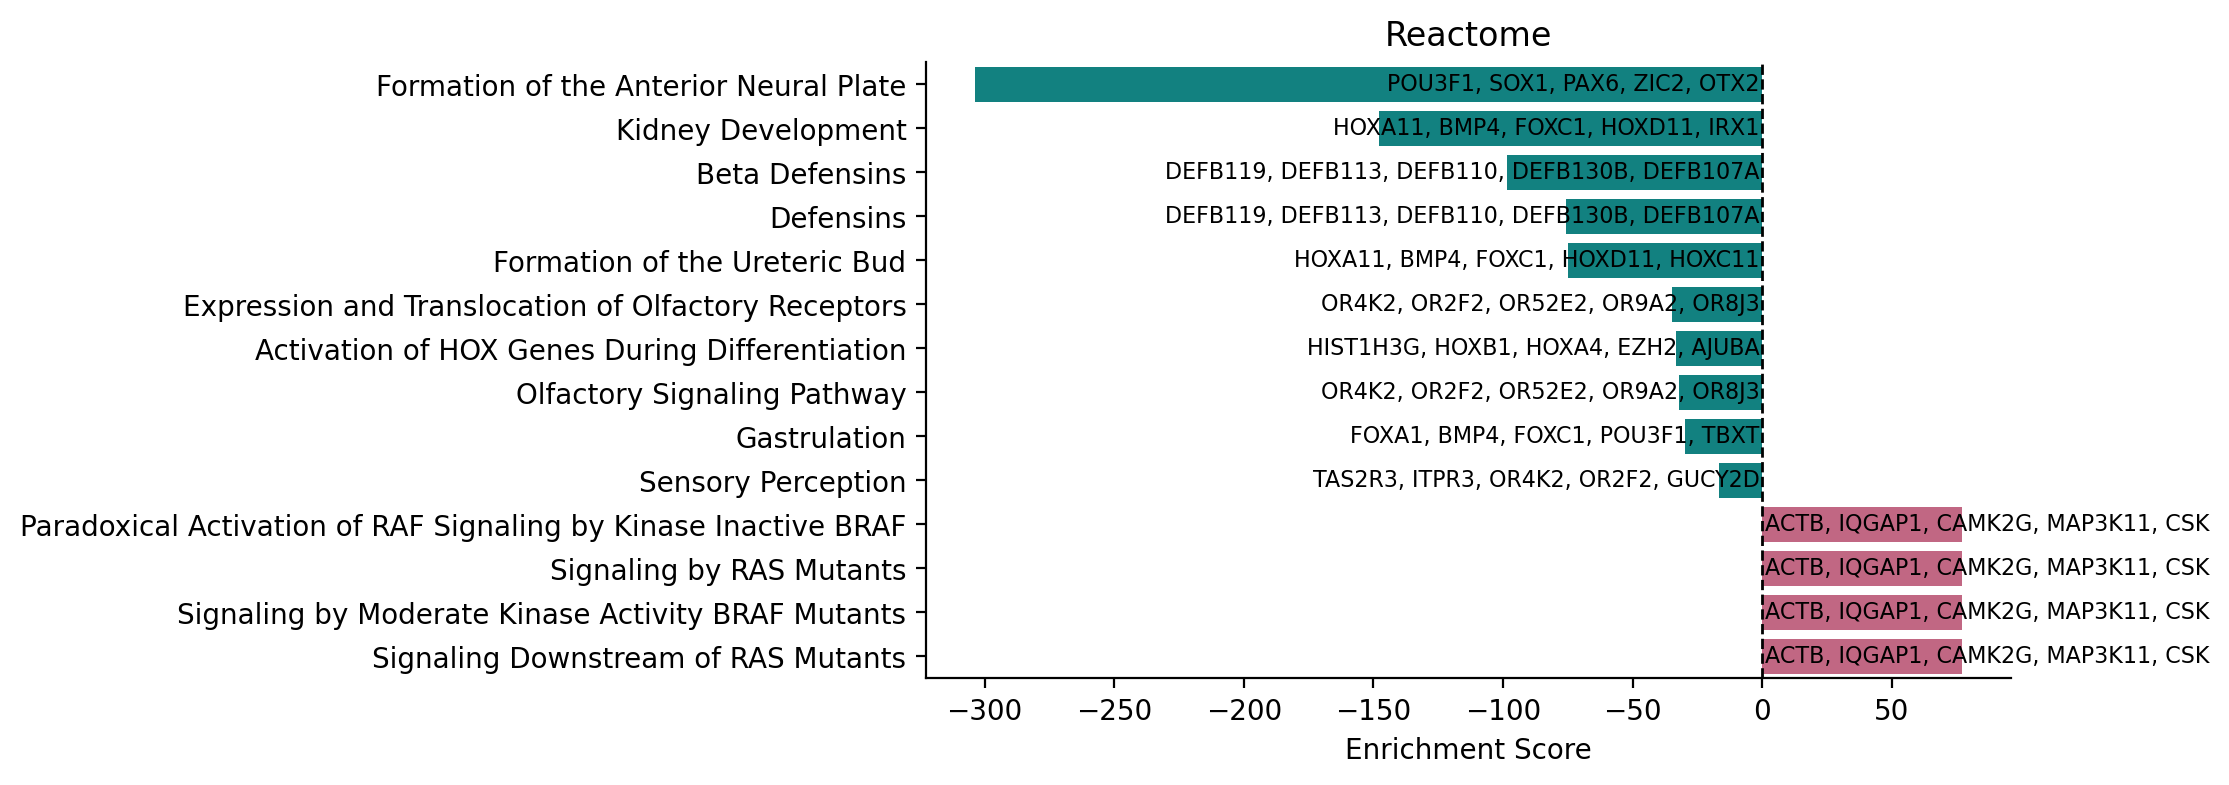

In [35]:
# plot the results with plot_enrichment_analysis
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
plot_enrichment_analysis(activating_go, repressive_go,   axes, repressive_complete_overlap_df['feature'].tolist(), activating_complete_overlap_df['feature'].tolist(), [TealRose_3.mpl_colors[0], TealRose_3.mpl_colors[2]])
axes.set_title('Gene Ontology Biological Process')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/enrichments/go_biological_process.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)
fig, axes2 = plt.subplots(1, 1, figsize = (7, 4))
plot_enrichment_analysis(activating_reactome, repressive_reactome,   axes2, repressive_complete_overlap_df['feature'].tolist(), activating_complete_overlap_df['feature'].tolist(), [TealRose_3.mpl_colors[0], TealRose_3.mpl_colors[2]])
axes2.set_title('Reactome')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/enrichments/reactome.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)


# Supp age assoc

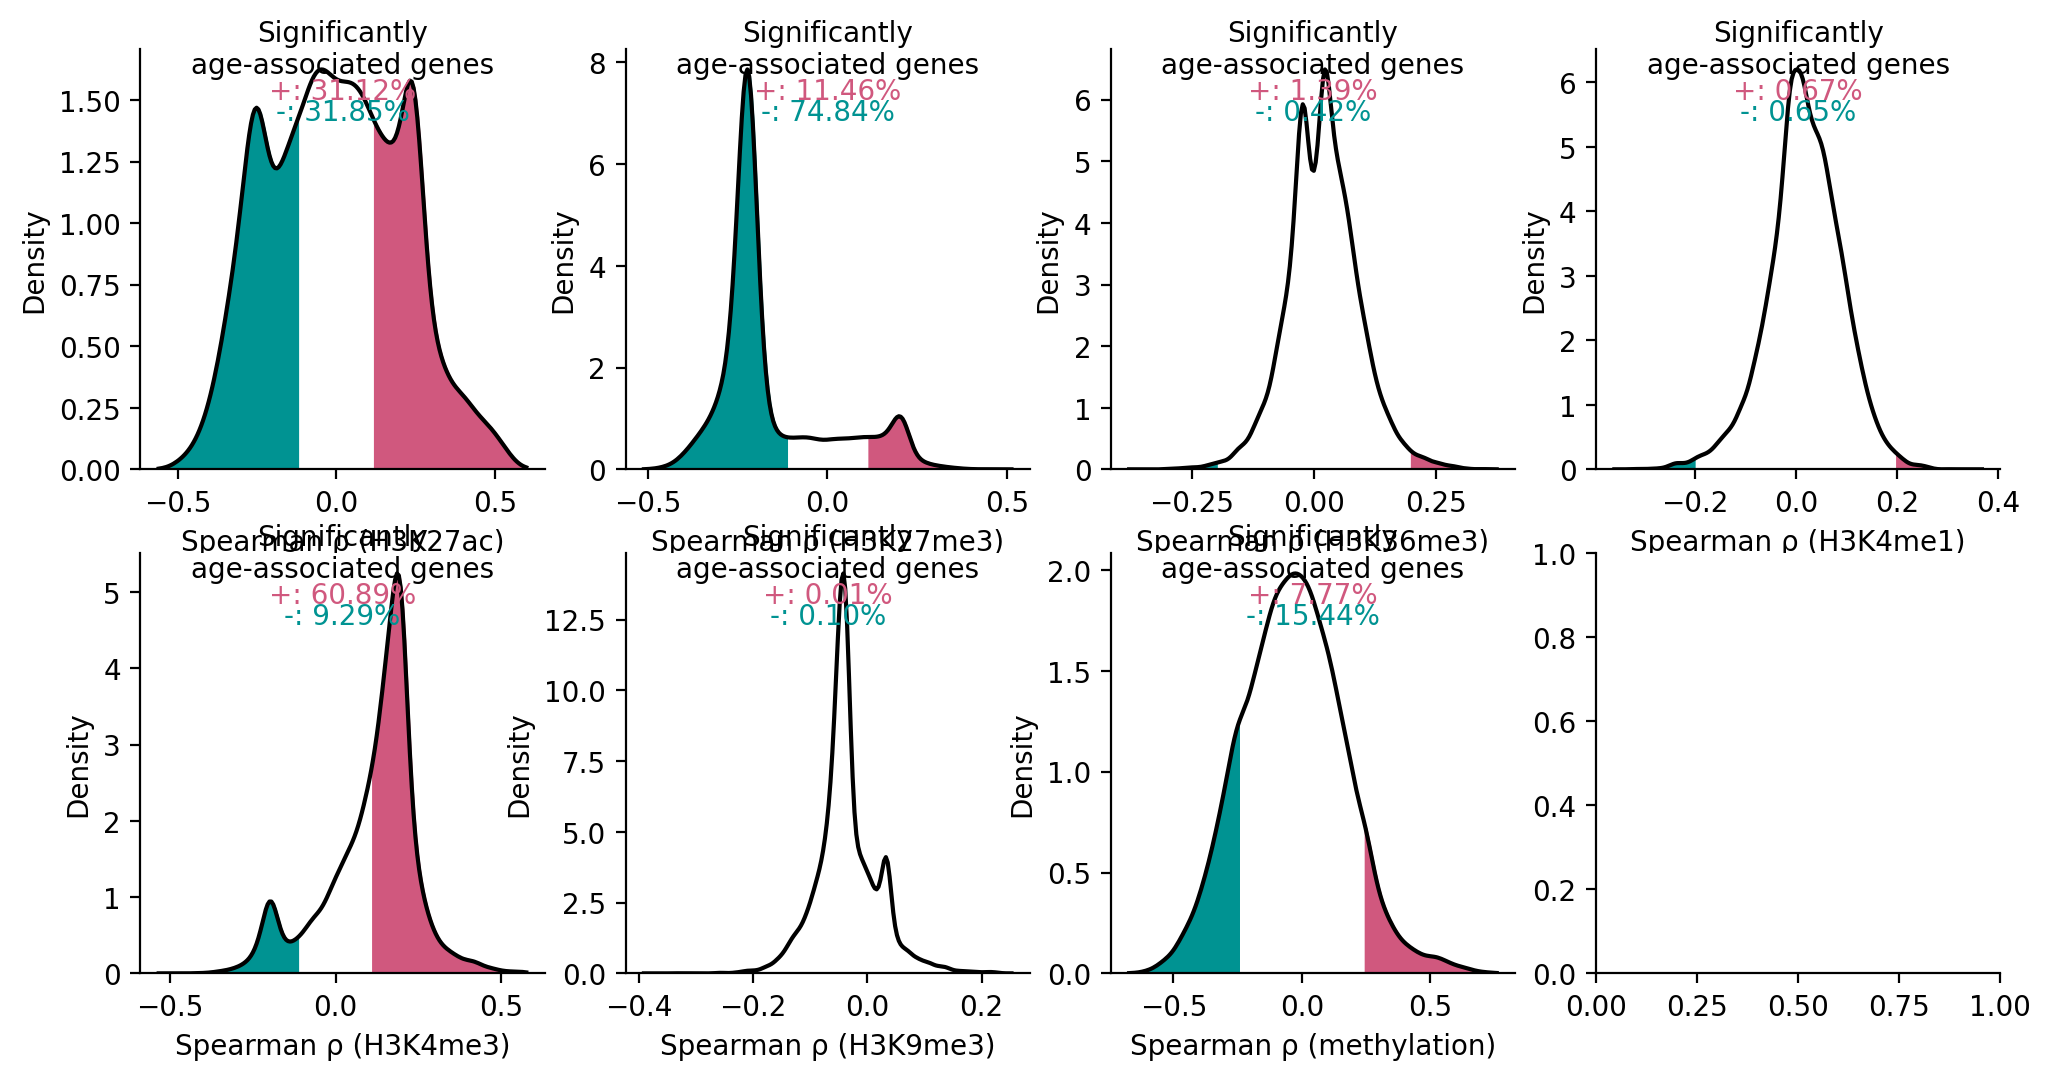

<Figure size 640x480 with 0 Axes>

In [40]:
# create facet grid of kde plots
# Create figure with subplots for each histone mark
fig, axes = plt.subplots(2, 4, 
                        figsize=(12, 6),
                        sharex = False,
                        )
axes = axes.flatten()
# Plot KDE for each histone mark
for i, (hmark, ax) in enumerate(zip(correlations['histone_mark'].unique(), axes)):
    # Get data for this histone mark
    hmark_data = correlations.query('species == "human" and histone_mark == @hmark')
    
    # Calculate KDE for all data
    kde = sns.kdeplot(data=hmark_data,
                      x='correlation',
                      ax=ax,
                      color='black',
                      fill=False,
                      cut=0)
    
    # Get the KDE curve data
    line = ax.get_lines()[-1]
    x = line.get_xdata()
    y = line.get_ydata()
    
    # get the minimum x value
    min_x = min(x)
    max_x = max(x)
    # get maximum significant negative x value
    max_sig_neg_x = hmark_data.query('q_value < 0.05 and correlation < 0')['correlation'].max()
    # get minimum significant positive x value
    min_sig_pos_x = hmark_data.query('q_value < 0.05 and correlation > 0')['correlation'].min()
    
    # Plot the filled KDE between the minimum x value and the minimum significant x value
    # Fill the negative significant region
    ax.fill_between(x[(x >= min_x) & (x <= max_sig_neg_x)], 
                   y[(x >= min_x) & (x <= max_sig_neg_x)], 
                   color=TealRose_3.mpl_colors[0], 
                   alpha=1,
                   label='Negative Significant')
    
    # Fill the positive significant region  
    ax.fill_between(x[(x >= min_sig_pos_x) & (x <= max_x)],
                   y[(x >= min_sig_pos_x) & (x <= max_x)],
                   color=TealRose_3.mpl_colors[2],
                   alpha=1, 
                   label='Positive Significant')
    
    # Get significant data points
    sig_data = hmark_data.query('q_value < 0.05')
    
    # Customize plot
    ax.set_xlabel('Spearman ρ ({})'.format(hmark))
    ax.set_ylabel('Density')
    # turn off legend
    ax.legend().remove()
    
    # add as text the percentage of genes that are significant up and down
    ax.text(0.5,1, 'Significantly\nage-associated genes',
            ha='center', va='center', transform=ax.transAxes, color = 'black', alpha = 1)
    ax.text(0.5, 0.9, '+: {:.2f}%'.format(len(sig_data.query('correlation > 0')) / len(hmark_data) * 100),
            ha='center', va='center', transform=ax.transAxes, color = TealRose_3.mpl_colors[2], alpha = 1)
    ax.text(0.5, 0.85, '-: {:.2f}%'.format(len(sig_data.query('correlation < 0')) / len(hmark_data) * 100),
            ha='center', va='center', transform=ax.transAxes, color = TealRose_3.mpl_colors[0], alpha = 1)

sns.despine()
plt.show()
plt.tight_layout()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/age_association/human_kde.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

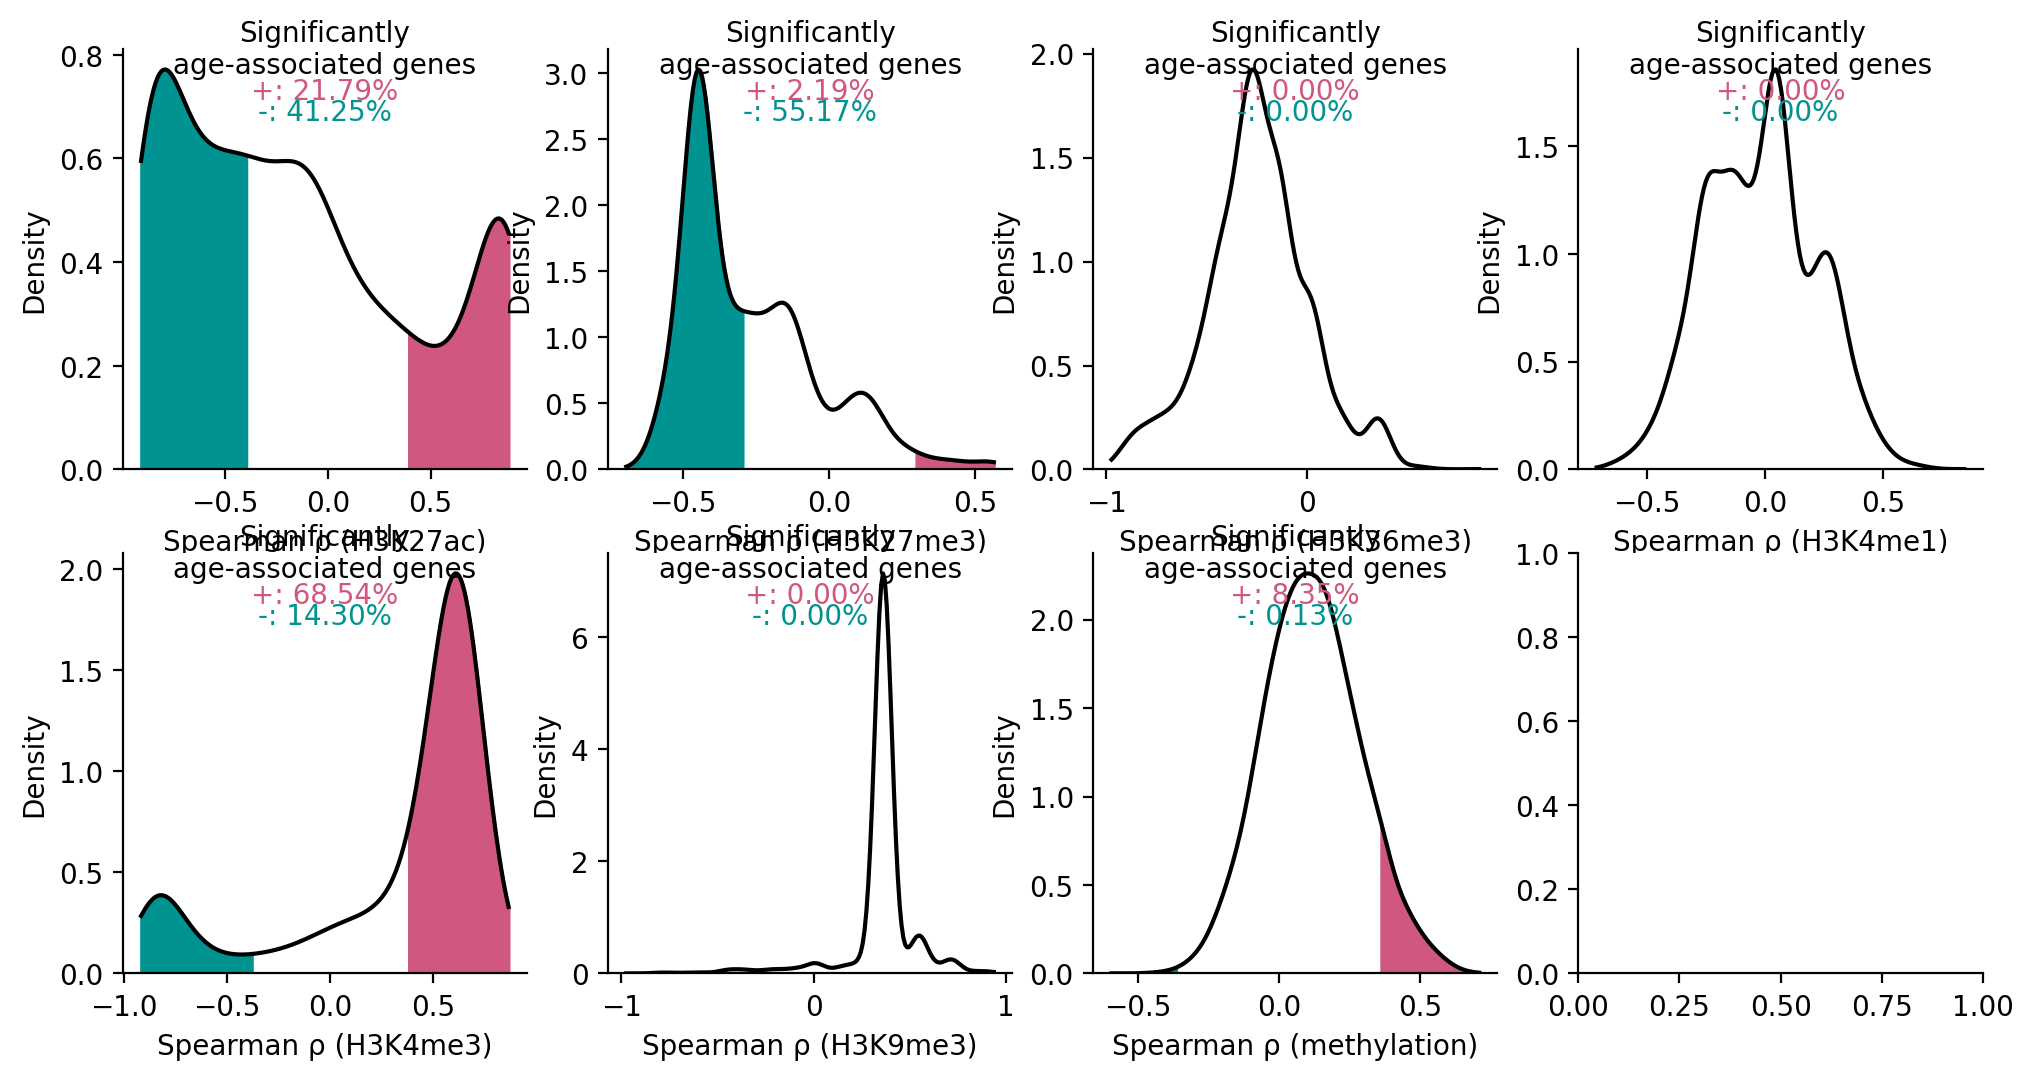

In [50]:
# create facet grid of kde plots
# Create figure with subplots for each histone mark
fig, axes = plt.subplots(2, 4, 
                        figsize=(12, 6),
                        sharex = False,
                        )
axes = axes.flatten()
# Plot KDE for each histone mark
for i, (hmark, ax) in enumerate(zip(correlations['histone_mark'].unique(), axes)):
    # Get data for this histone mark
    hmark_data = correlations.query('species == "mouse" and histone_mark == @hmark')
    
    # Calculate KDE for all data
    kde = sns.kdeplot(data=hmark_data,
                      x='correlation',
                      ax=ax,
                      color='black',
                      fill=False,
                      bw_adjust = 1.5,
                      cut=0)
    
    # Get the KDE curve data
    line = ax.get_lines()[-1]
    x = line.get_xdata()
    y = line.get_ydata()
    
    # get the minimum x value
    min_x = min(x)
    max_x = max(x)
    # get maximum significant negative x value
    max_sig_neg_x = hmark_data.query('q_value < 0.05 and correlation < 0')['correlation'].max()
    # get minimum significant positive x value
    min_sig_pos_x = hmark_data.query('q_value < 0.05 and correlation > 0')['correlation'].min()
    ax.fill_between(x[(x >= min_x) & (x <= max_sig_neg_x)], 
                   y[(x >= min_x) & (x <= max_sig_neg_x)], 
                   color=TealRose_3.mpl_colors[0], 
                   alpha=1,
                   label='Negative Significant')
    
    # Fill the positive significant region  
    ax.fill_between(x[(x >= min_sig_pos_x) & (x <= max_x)],
                   y[(x >= min_sig_pos_x) & (x <= max_x)],
                   color=TealRose_3.mpl_colors[2],
                   alpha=1, 
                   label='Positive Significant')
    
    # Get significant data points
    sig_data = hmark_data.query('q_value < 0.05')
    
    # Customize plot
    ax.set_xlabel('Spearman ρ ({})'.format(hmark))
    ax.set_ylabel('Density')
    # turn off legend
    ax.legend().remove()
    
    # add as text the percentage of genes that are significant up and down
    ax.text(0.5,1, 'Significantly\nage-associated genes',
            ha='center', va='center', transform=ax.transAxes, color = 'black', alpha = 1)
    ax.text(0.5, 0.9, '+: {:.2f}%'.format(len(sig_data.query('correlation > 0')) / len(hmark_data) * 100),
            ha='center', va='center', transform=ax.transAxes, color = TealRose_3.mpl_colors[2], alpha = 1)
    ax.text(0.5, 0.85, '-: {:.2f}%'.format(len(sig_data.query('correlation < 0')) / len(hmark_data) * 100),
            ha='center', va='center', transform=ax.transAxes, color = TealRose_3.mpl_colors[0], alpha = 1)

sns.despine()
plt.show()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/age_association/mouse_kde.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [90]:
(correlations.query('q_value < 0.05 and species == "human"').groupby(['histone_mark'])['feature'].nunique() / correlations['feature'].nunique())

histone_mark
H3K27ac        0.629725
H3K27me3       0.863057
H3K36me3       0.018143
H3K4me1        0.013200
H3K4me3        0.701792
H3K9me3        0.001011
methylation    0.232040
Name: feature, dtype: float64

In [85]:
(correlations.query('q_value < 0.05').groupby(['histone_mark', 'species'])['feature'].nunique() / correlations['feature'].nunique()).describe()

count    11.000000
mean      0.416008
std       0.347044
min       0.001011
25%       0.051452
50%       0.573555
75%       0.666096
max       0.863057
Name: feature, dtype: float64

# Supp entropy

In [5]:
entropy_df = pan_epigenetic.calculate_shannon_entropy(input_df = pan_epigenetic.combined_data_matrix.iloc[:, :-24])
# join in the relevant metadata
entropy_df = entropy_df.to_frame().join(pan_epigenetic.combined_data_matrix[['tissue', 'histone_mark', 'donor', 'age_years', 'species', 'dataset','general_tissue', 'age_scaled_loglog']])
entropy_df.rename(columns = {0: 'entropy_shannon'}, inplace = True)

In [ ]:
['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1']

In [6]:
entropy_df['dataset'].value_counts()

dataset
human_encode_hmark        1192
human_blueprint_hmark      666
hillje                      69
human_blueprint_methyl      65
stubbs_methyl               62
yang_2023                   42
methyl_human_encode         41
signal_2024                 39
Name: count, dtype: int64

In [7]:
entropy_df.query("dataset == 'CEEHRC'").groupby(['species', 'histone_mark'])[['entropy_shannon', 'age_years', 'age_scaled_loglog']].corr(method = 'pearson')

,,entropy_shannon,age_years,age_scaled_loglog
species,histone_mark,,,
